### Table of Contents 
1. Data Exploration
2. Data Pre-processing
3. Model Implementation and Evaluation

## Step 1. DATA EXPLORATION

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# Read the dataset and display the columns 
df = pd.read_csv('clinical_events_raw.csv')
# print(df.head())


### Drop unnecessary columns

In [3]:
# Check if the first two columns are the same
print(all(df.iloc[:, 0] == df.iloc[:, 1]))


True


In [4]:
# Check if the last column has only one unique value
print(df['member_male'].nunique())

1


In [5]:
# Drop the first and last columns
if all(df.iloc[:, 0] == df.iloc[:, 1]) and df.iloc[:, -1].nunique() == 1:
    df = df.drop(df.columns[[0, 1, -1]], axis=1)



It seems like the first two columns are identical and the last column is constant, so they don't provide any useful information the machine learning model and can be removed.

In [6]:
# Check number of patients
print(df.iloc[:, 0].nunique())

200000


In [7]:
# check unique clinical events
print(df['clinical_event_name'].unique()) 


['ANNUAL VISIT' 'STROKE HOSPITALIZATION' 'HYPERTENSION MANAGEMENT VISIT'
 'DIABETES MANAGEMENT VISIT' 'ATRIAL FIBRILLATION'
 'HEART FAILURE HOSPITALIZATION']


In [8]:
#check column names
print(df.columns)


Index(['clinical_event_member_id', 'clinical_event_name',
       'clinical_event_time', 'clinical_event_member_age'],
      dtype='object')


### Rename column and event names 


In [9]:
df.columns = ['Member_ID', 'Event_Name', 'Event_Time', 'Member_Age']

In [10]:
df['Event_Name'] = df['Event_Name'].replace({
    'ANNUAL VISIT': 'AnnVis',
    'HYPERTENSION MANAGEMENT VISIT': 'HypTenManVis',
    'DIABETES MANAGEMENT VISIT': 'DiaManVis',
    'HEART FAILURE HOSPITALIZATION': 'HeartFailHosp',
    'STROKE HOSPITALIZATION': 'StrHosp',
    'ATRIAL FIBRILLATION': 'AtrFib'
})
df.head()

,Member_ID,Event_Name,Event_Time,Member_Age
0,1,AnnVis,41,81
1,1,StrHosp,641,81
2,1,HypTenManVis,116,81
3,1,HypTenManVis,293,81
4,2,AnnVis,14,76


### Visualize event times for insights into temporal aspects

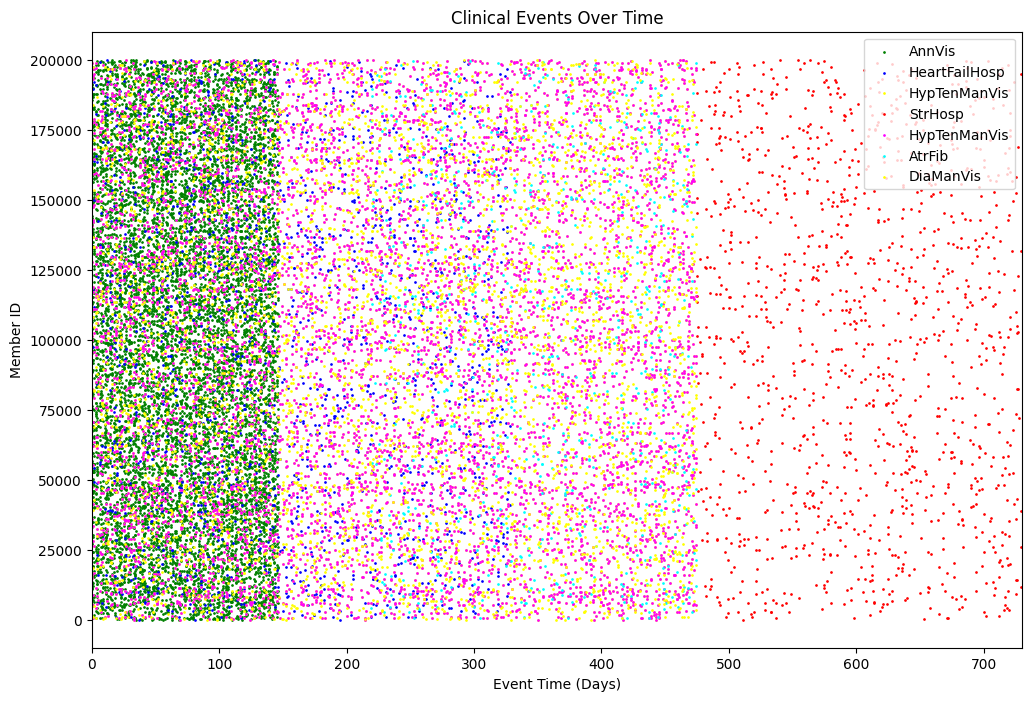

In [11]:
import matplotlib.pyplot as plt
# Sample 10,000 unique members
unique_members = df['Member_ID'].unique()
sampled_members = np.random.choice(unique_members, size=10000, replace=False)

# Filter the dataframe to only include sampled members
df_sampled = df[df['Member_ID'].isin(sampled_members)]

# Create the plot figure
plt.figure(figsize=(12,8))

# Plot each event type separately so they can have different colors
for event, color in [('AnnVis', 'green'), 
                     ('HeartFailHosp','blue'),
                     ('HypTenManVis','yellow'),
                     ('StrHosp', 'red'),
                     ('HypTenManVis', 'magenta'),
                     ('AtrFib', 'cyan'),
                     ('DiaManVis','yellow')]:
    df_event = df_sampled[df_sampled['Event_Name'] == event]
    plt.scatter(df_event['Event_Time'], df_event['Member_ID'], color=color, s=0.9, label=event)

# Labeling the plot
plt.xlabel('Event Time (Days)')
plt.ylabel('Member ID')
plt.title('Clinical Events Over Time')
plt.xlim(0, df['Event_Time'].max())
plt.legend()

# Display the plot
plt.show()

####
Seems like the data contains interesting temporal aspects so I'd like to maximize the timestamp benefots in modeling. 
I'm thinking about creating new features for each patient like "time since this visit X" for visit Y but that might lead to too many features. 
We can rather just normalize the data for each patient by substracting the day of annual visit from each time point. 



### skipped: normalize times by annual visit time


In [ ]:
'''
# Filter rows with 'ANNUAL VISIT'
annual_visit_df = df[df['Event_Name'] == 'AnnVis'][['Member_ID', 'Event_Time']]

# Rename the column for merging
annual_visit_df.rename(columns={'Event_Time': 'Annual_Visit_Time'}, inplace=True)

# Merge the annual visit times with the original dataframe
df = pd.merge(df, annual_visit_df, on='Member_ID')

# Calculate the time difference
df['Event_Time'] = df['Event_Time'] - df['Annual_Visit_Time']

#drop the annual visit time column as it's no longer needed and shouldn't provide any insights 
df.drop('Annual_Visit_Time',axis=1,inplace=True)

#This code assumes that each patient only has one annual visit. Additionally, it will result in negative values for events that occur before the annual visit. 

df.head()
'''

### Explore event distribution and temporal aspects

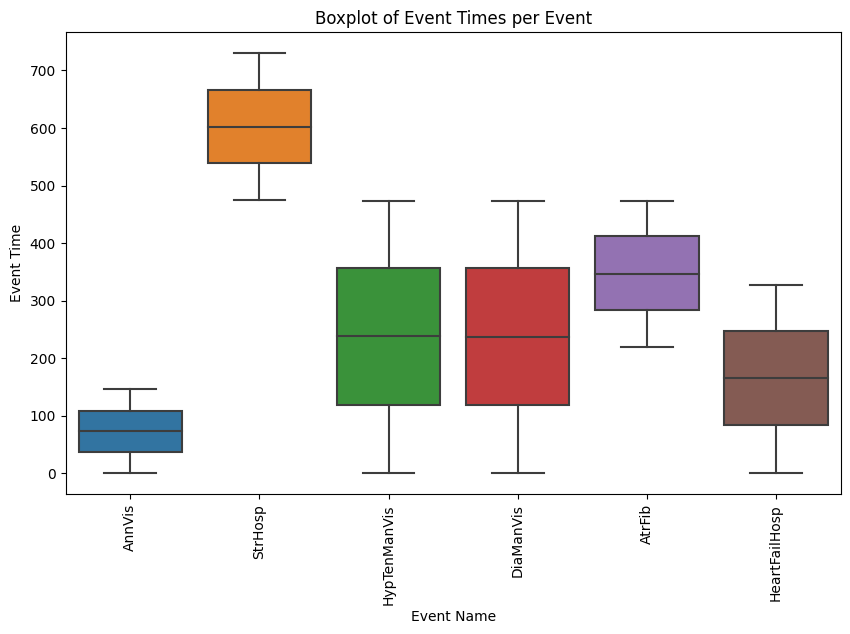

Summary Statistics:
            Member_ID     Event_Time     Member_Age
count  511846.000000  511846.000000  511846.000000
mean   100045.459302     188.899161      73.197186
std     57797.624855     160.707576       7.211483
min         1.000000       0.000000      60.000000
25%     49939.250000      64.000000      67.000000
50%    100122.000000     129.000000      74.000000
75%    150001.000000     296.000000      80.000000
max    200000.000000     730.000000      85.000000


In [13]:
import seaborn as sns

# Boxplot of event times per event
plt.figure(figsize=(10, 6))
sns.boxplot(x='Event_Name', y='Event_Time', data=df)
plt.title('Boxplot of Event Times per Event')
plt.xlabel('Event Name')
plt.ylabel('Event Time')
plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility
plt.show()

# 4. Summary statistics
print("Summary Statistics:\n", df.describe())


In [15]:
# Event Distribution
event_distribution = df['Event_Name'].value_counts()
print("Event Distribution:\n", event_distribution)


Event Distribution:
 AnnVis           200000
HypTenManVis     153326
DiaManVis         86840
HeartFailHosp     33606
StrHosp           24821
AtrFib            13253
Name: Event_Name, dtype: int64


In [16]:
# Temporal Aspects
print("Event Time Description:\n", df['Event_Time'].describe())


Event Time Description:
 count    511846.000000
mean         26.985594
std          22.958225
min           0.000000
25%           9.142857
50%          18.428571
75%          42.285714
max         104.285714
Name: Event_Time, dtype: float64


## Step 2. DATA PRE-PROCESSING

### Convert to a wide format


To facilitate further analysis, I converted the dataset from long format to wide format. I created binary columns for each type of clinical visit. If a patient had a certain type of visit, that corresponding column was marked as 1; otherwise, it was 0. Similarly, I created columns for the event time for each type of visit.

Realizing that patients could have multiple visits of the same type, I further enhanced our dataset by adding the count of each type of clinical visit for each patient. 

The transformations I made aimed to provide a holistic view of each patient's clinical visit history in one row, allowing for more efficient and effective predictive modeling. For instance, it could now be much easier to predict the likelihood of a stroke based on a patient's age, the type of clinical visits they had, the timing of those visits, and the frequency of those visits.



In [17]:

# Define the names of the clinical events
event_names = ['AnnVis', 'HypTenManVis', 'DiaManVis', 'HeartFailHosp', 'StrHosp', 'AtrFib']

# Create binary variables for each clinical event type
for name in event_names:
    df[name] = (df['Event_Name'] == name).astype(int)

# Create pivot tables for event occurrences and times
occurrence_pivot = df.pivot_table(index='Member_ID', values=event_names, aggfunc='sum')
time_pivot = df.pivot_table(index='Member_ID', values='Event_Time', columns='Event_Name', aggfunc='mean')

# Rename the columns
occurrence_pivot.columns = [f"{name}_Count" for name in occurrence_pivot.columns]
time_pivot.columns = [f"{name}_Time" for name in time_pivot.columns]

# Get member ages
member_ages = df[['Member_ID', 'Member_Age']].drop_duplicates()

# Join the tables
df_new = member_ages.join(occurrence_pivot, on='Member_ID').join(time_pivot, on='Member_ID')

# Create a binary 'Stroke' column and remove 'StrHosp_Count' and 'StrHosp_Time' columns
df_new['Stroke'] = (df_new['StrHosp_Count'] > 0).astype(int)
df_new.drop(['StrHosp_Count', 'StrHosp_Time'], axis=1, inplace=True)



# Save the new DataFrame to a CSV file
#df_new.to_csv('clinical_events_transformed.csv', index=False)

df_new


,Member_ID,Member_Age,AnnVis_Count,AtrFib_Count,DiaManVis_Count,HeartFailHosp_Count,HypTenManVis_Count,AnnVis_Time,AtrFib_Time,DiaManVis_Time,HeartFailHosp_Time,HypTenManVis_Time,Stroke
0,1,81,1,0,0,0,2,5.857143,NaN,NaN,NaN,29.214286,1
4,2,76,1,0,3,0,0,2.000000,NaN,43.857143,NaN,NaN,0
8,3,70,1,1,0,0,1,12.714286,48.428571,NaN,NaN,43.571429,1
12,4,85,1,0,0,3,5,11.428571,NaN,NaN,27.047619,26.057143,1
22,5,77,1,0,0,0,0,16.857143,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
511831,199996,61,1,0,0,0,0,15.000000,NaN,NaN,NaN,NaN,0
511832,199997,77,1,0,0,0,0,3.428571,NaN,NaN,NaN,NaN,0
511833,199998,78,1,0,0,4,5,7.571429,NaN,NaN,32.250000,39.800000,1
511844,199999,68,1,0,0,0,0,19.142857,NaN,NaN,NaN,NaN,0


In [18]:
#Drop Member ID column 
df_new.drop(['Member_ID'], axis=1, inplace=True)


In [19]:
#convert nan to zero 
df_new = df_new.fillna(0)


In [20]:
# List of your continuous variables (all columns except 'Stroke')
continuous_vars = df_new.columns.drop('Stroke').tolist()

# Skewness along the index axis
print("Original skew:\n", (df_new[continuous_vars]).skew(axis = 0))

# Skew for sqrt transformation
print("\nSkew after sqrt transformation:\n", np.sqrt(df_new[continuous_vars]).skew(axis = 0))

# Skew for log10 transformation
print("\nSkew after log10 transformation:\n", np.log10(df_new[continuous_vars] + 1).skew(axis = 0))

# Apply the transformations based on what improved the skewness
# In this case, I apply log transformation to all variables.
for var in continuous_vars:
    df_new[var] = np.log10(df_new[var] + 1)

# Checking skew after transformation
print("\nSkew after transformation:\n", df_new[continuous_vars].skew(axis = 0))


Original skew:
 Member_Age            -0.001125
AnnVis_Count           0.000000
AtrFib_Count           5.133444
DiaManVis_Count        3.576681
HeartFailHosp_Count    4.599974
HypTenManVis_Count     2.603738
AnnVis_Time            0.003576
AtrFib_Time            4.668877
DiaManVis_Time         2.646035
HeartFailHosp_Time     3.928311
HypTenManVis_Time      1.837104
dtype: float64

Skew after sqrt transformation:
 Member_Age            -0.061876
AnnVis_Count           0.000000
AtrFib_Count           4.638060
DiaManVis_Count        2.468493
HeartFailHosp_Count    3.467547
HypTenManVis_Count     1.727605
AnnVis_Time           -0.570201
AtrFib_Time            4.488946
DiaManVis_Time         2.272571
HeartFailHosp_Time     3.378645
HypTenManVis_Time      1.516406
dtype: float64

Skew after log10 transformation:
 Member_Age            -0.121258
AnnVis_Count           0.000000
AtrFib_Count           4.783798
DiaManVis_Count        2.491336
HeartFailHosp_Count    3.612110
HypTenManVis_Count   


It looks like  skewness values have generally been reduced, which is good for making the data more symmetric. However, some variables still have high skewness values. For instance, Stroke, AtrFib_Count, DiaManVis_Count, HeartFailHosp_Count, and HypTenManVis_Count are all fairly skewed.

This is important when using a statistical model that requires normally distributed data (like a linear regression), it might be beneficial to address these high skewness values. 

On the other hand, when using a model that doesn't make strict assumptions about the distributions of your features (like a decision tree or a random forest), addressing the skewness might not be necessary.

In terms of transformations, other than the sqrt and log transformations, there are many other transformations we might consider, including Box-Cox transformation,Yeo-Johnson transformation, Quantile transformation, etc

## Data Scaling

In [ ]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Define the columns to scale
cols_to_scale = ['Member_Age', 'AnnVis_Count', 'AtrFib_Count', 'DiaManVis_Count',
                 'HeartFailHosp_Count', 'HypTenManVis_Count', 'AnnVis_Time', 
                 'AtrFib_Time', 'DiaManVis_Time', 'HeartFailHosp_Time', 'HypTenManVis_Time']

# Apply the scaler to the columns
df_new[cols_to_scale] = scaler.fit_transform(df_new[cols_to_scale])



In [22]:
df_new

,Member_Age,AnnVis_Count,AtrFib_Count,DiaManVis_Count,HeartFailHosp_Count,HypTenManVis_Count,AnnVis_Time,AtrFib_Time,DiaManVis_Time,HeartFailHosp_Time,HypTenManVis_Time,Stroke
0,1.150290,0.0,-0.209975,-0.382577,-0.283057,1.281063,-0.425108,-0.215308,-0.397269,-0.291778,1.823787,1
4,0.515399,0.0,-0.209975,2.476496,-0.283057,-0.500418,-1.570762,-0.215308,2.744607,-0.291778,-0.523823,0
8,-0.303274,0.0,3.461420,-0.382577,-0.283057,0.623572,0.535492,4.625513,-0.397269,-0.291778,2.091573,1
12,1.630926,0.0,-0.209975,-0.382577,4.257023,2.405052,0.399068,-0.215308,-0.397269,3.607638,1.747770,1
22,0.645613,0.0,-0.209975,-0.382577,-0.283057,-0.500418,0.901309,-0.215308,-0.397269,-0.291778,-0.523823,0
...,...,...,...,...,...,...,...,...,...,...,...,...
511831,-1.671124,0.0,-0.209975,-0.382577,-0.283057,-0.500418,0.749122,-0.215308,-0.397269,-0.291778,-0.523823,0
511832,0.645613,0.0,-0.209975,-0.382577,-0.283057,-0.500418,-1.031021,-0.215308,-0.397269,-0.291778,-0.523823,0
511833,0.774168,0.0,-0.209975,-0.382577,4.987813,2.405052,-0.115864,-0.215308,-0.397269,3.806650,2.030677,1
511844,-0.591621,0.0,-0.209975,-0.382577,-0.283057,-0.500418,1.068229,-0.215308,-0.397269,-0.291778,-0.523823,0


## Handling data imbalance

0    140143
1     19857
Name: Stroke, dtype: int64


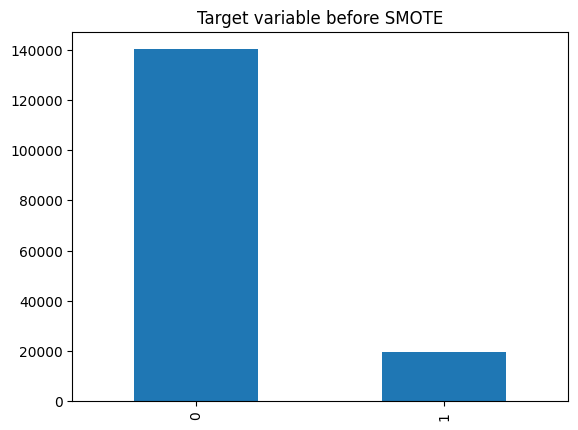

Samples in the original dataset:  160000
Samples in the resampled dataset:  276626


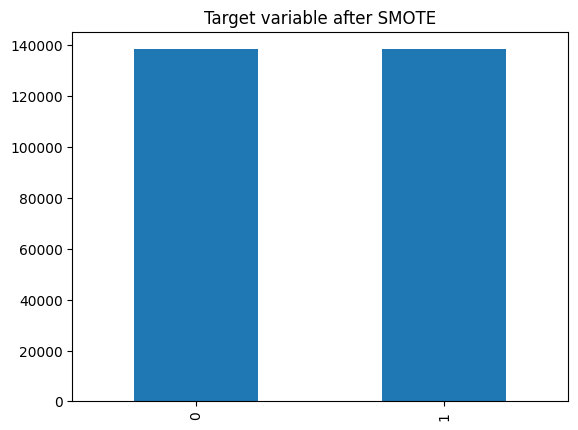

In [23]:
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTETomek

# Define your feature matrix 'X' and target variable 'y'
X = df_new.drop(columns=['Stroke'])
y = df_new['Stroke']

# Split your data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3697, stratify=y, shuffle=True)

# Check distribution of target variable
print(y_train.value_counts())

# Visualize the target variable before SMOTE
y_train.value_counts().plot(kind='bar', title='Target variable before SMOTE')
plt.show()

# Perform SMOTE only if the target variable is highly imbalanced
X_smote, y_smote = SMOTETomek(random_state=0).fit_resample(X_train, y_train)

print('Samples in the original dataset: ', len(y_train))
print('Samples in the resampled dataset: ', len(y_smote))

# Visualize the target variable after SMOTE
y_smote.value_counts().plot(kind='bar', title='Target variable after SMOTE')
plt.show()


## Step 3. MODEL IMPLEMENTATION AND EVALUATION

In [50]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import RepeatedStratifiedKFold
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')


In [41]:
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report, accuracy_score

def evaluate_model(model, X_train, X_test, y_train, y_test):
    features = X_train.columns.tolist()

    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the train and test data
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    pred_prob_train = model.predict_proba(X_train)[:,1]
    pred_prob_test = model.predict_proba(X_test)[:,1]

    # Calculate and print ROC AUC scores
    roc_auc_train = roc_auc_score(y_train, pred_prob_train)
    roc_auc_test = roc_auc_score(y_test, pred_prob_test)
    print("\nTrain ROC AUC:", roc_auc_train)
    print("Test ROC AUC:", roc_auc_test)

    # Plot ROC curves
    fpr_train, tpr_train, thresholds_train = roc_curve(y_train, pred_prob_train)
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, pred_prob_test)
    plt.plot([0,1],[0,1],'k--')
    plt.plot(fpr_train, tpr_train, label="Train ROC AUC: {:.2f}".format(roc_auc_train))
    plt.plot(fpr_test, tpr_test, label="Test ROC AUC: {:.2f}".format(roc_auc_test))
    plt.legend()
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.show()

    # Calculate confusion matrices
    cm_train = confusion_matrix(y_train, y_pred_train)
    cm_test = confusion_matrix(y_test, y_pred_test)

    # Plot confusion matrices
    fig, ax = plt.subplots(1, 2, figsize=(11,4))
    sns.heatmap(cm_train, annot=True, fmt='g', cmap="Oranges", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'], ax=ax[0])
    ax[0].set_title("Train Confusion Matrix")
    ax[0].set_xlabel("Predicted Label")
    ax[0].set_ylabel("True Label")
    sns.heatmap(cm_test, annot=True, fmt='g', cmap="Oranges", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'], ax=ax[1])
    ax[1].set_title("Test Confusion Matrix")
    ax[1].set_xlabel("Predicted Label")
    ax[1].set_ylabel("True Label")
    plt.show()

    # Generate classification reports
    cr_train = classification_report(y_train, y_pred_train, output_dict=True)
    cr_test = classification_report(y_test, y_pred_test, output_dict=True)
    print("\nTrain Classification Report:")
    print(pd.DataFrame(cr_train).transpose())
    print("\nTest Classification Report:")
    print(pd.DataFrame(cr_test).transpose())

    # Plot feature importances, if applicable
    try:
        try:
            feature_importance = model.feature_importances_
        except:
            feature_importance = model.coef_[0]

        feature_importance = np.abs(feature_importance)
        feat = pd.Series(feature_importance, index=features)
        feat = feat.sort_values(ascending=True)
        plt.figure(figsize=(10,6))
        plt.title('Feature Importances for '+str(model))
        plt.xlabel('Relative Importance')
        feat.plot(kind='barh', colormap='Dark2')
        plt.show()
    except AttributeError:
        print("\nThe model does not have feature importances attribute.")

    # Return model evaluation metrics
    precision_train = cr_train['weighted avg']['precision']
    precision_test = cr_test['weighted avg']['precision']
    recall_train = cr_train['weighted avg']['recall']
    recall_test = cr_test['weighted avg']['recall']
    acc_train = accuracy_score(y_train, y_pred_train)
    acc_test = accuracy_score(y_test, y_pred_test)
    F1_train = cr_train['weighted avg']['f1-score']
    F1_test = cr_test['weighted avg']['f1-score']

    return [precision_train, precision_test, recall_train, recall_test, acc_train, acc_test, roc_auc_train, roc_auc_test, F1_train, F1_test]


In [34]:
# Create a score DataFrame
score = pd.DataFrame(index = ['Precision Train', 'Precision Test','Recall Train','Recall Test','Accuracy Train', 'Accuracy Test','ROC-AUC Train', 'ROC-AUC Test','F1 macro Train', 'F1 macro Test'])


In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


### ML Model - 1 : Logistic regression


Train ROC AUC: 0.887222991041833
Test ROC AUC: 0.8890371561186425


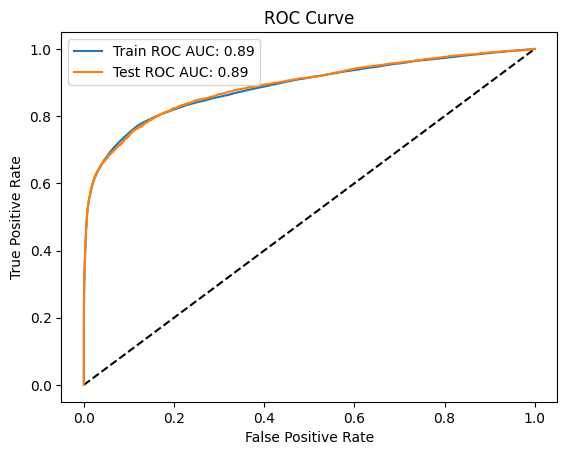

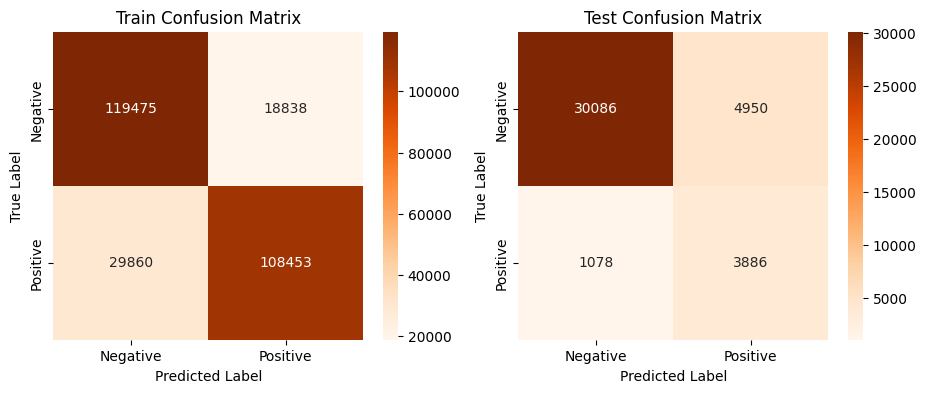


Train Classification Report:
              precision    recall  f1-score        support
0              0.800047  0.863802  0.830703  138313.000000
1              0.852008  0.784113  0.816652  138313.000000
accuracy       0.823957  0.823957  0.823957       0.823957
macro avg      0.826028  0.823957  0.823677  276626.000000
weighted avg   0.826028  0.823957  0.823677  276626.000000

Test Classification Report:
              precision    recall  f1-score     support
0              0.965409  0.858717  0.908943  35036.0000
1              0.439792  0.782836  0.563188   4964.0000
accuracy       0.849300  0.849300  0.849300      0.8493
macro avg      0.702600  0.820777  0.736066  40000.0000
weighted avg   0.900180  0.849300  0.866035  40000.0000


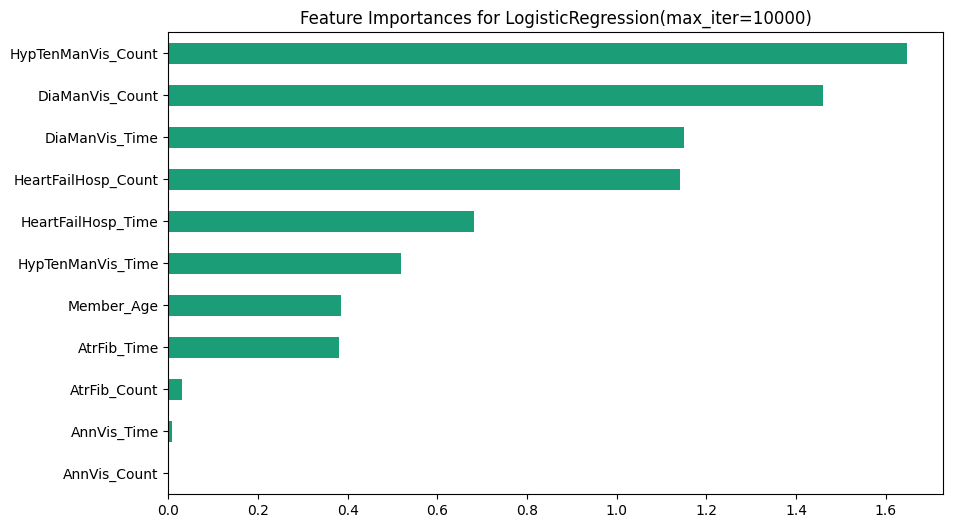

In [36]:


# ML Model 1: Logistic Regression
lr_model = LogisticRegression(fit_intercept=True, max_iter=10000)
lr_score = evaluate_model(lr_model, X_smote, X_test, y_smote, y_test)
score['Logistic regression'] = lr_score



#### Evaluation of these results
These results indicate that our model is performing well and consistently on both your training and test sets.

The Receiver Operating Characteristic (ROC) curve is showing the performance of our classification model. The area under it (AUC) represents the model's ability to distinguish between positive and negative classes - in our case, whether a patient had a stroke or not.

The ROC AUC values for training and test sets are 0.887 and 0.889, respectively. This indicates that the model is performing similarly and well on both datasets, which means the model is successfully generalizing well from the training data to unseen test data.


#### Improving Model Performance with Cross- Validation & Hyperparameter Tuning

I will still apply hyperparameter tuning and cross-validation for improving the model performance.

I perform hyperparameter tuning using GridSearchCV, which is a method that performs exhaustive search over specified parameter values for our model. The parameters will be optimized by cross-validated grid-search over a parameter grid (param_grid in our case).

In addition, I will use RepeatedStratifiedKFold for cross-validation for this project as we are dealing with an imbalanced dataset. It's a variation of KFold that returns stratified folds (each set contains approximately the same percentage of samples of each target class as the complete set)


#### 2. Cross- Validation & Hyperparameter Tuning

In [43]:
# ML Model - 1 Implementation with hyperparameter optimization techniques (i.e., GridSearch CV, RandomSearch CV, Bayesian Optimization etc.)
# Define the hyperparameter grid
param_grid = {'C': [100,10,1,0.1,0.01,0.001,0.0001],
              'penalty': ['l1', 'l2'],
              'solver':['liblinear']} #'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'

# Initializing the logistic regression model
logreg = LogisticRegression(fit_intercept=True, max_iter=10000, random_state=0)

# Repeated stratified kfold
rskf = RepeatedStratifiedKFold(n_splits=3, n_repeats=4, random_state=0)

# Using GridSearchCV to tune the hyperparameters using cross-validation
grid = GridSearchCV(logreg, param_grid, cv=rskf)
grid.fit(X_smote, y_smote)

# Select the best hyperparameters found by GridSearchCV
best_params = grid.best_params_
print("Best hyperparameters: ", best_params)

Best hyperparameters:  {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}


In [44]:
# Initiate model with best parameters
lr_model2 = LogisticRegression(C=best_params['C'],
                                  penalty=best_params['penalty'],
                                  solver=best_params['solver'],
                                  max_iter=10000, random_state=0)


Train ROC AUC: 0.8874186750671142
Test ROC AUC: 0.8893053331400169


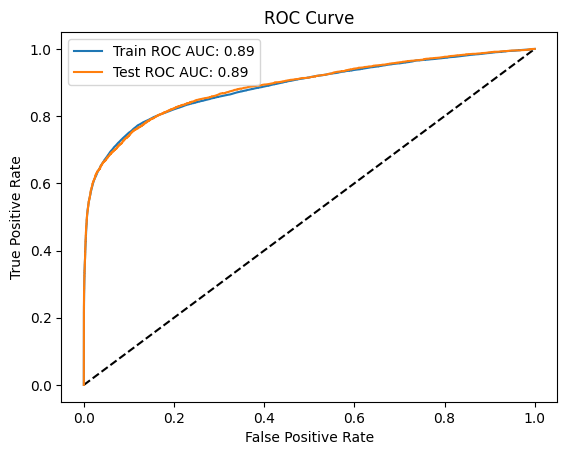

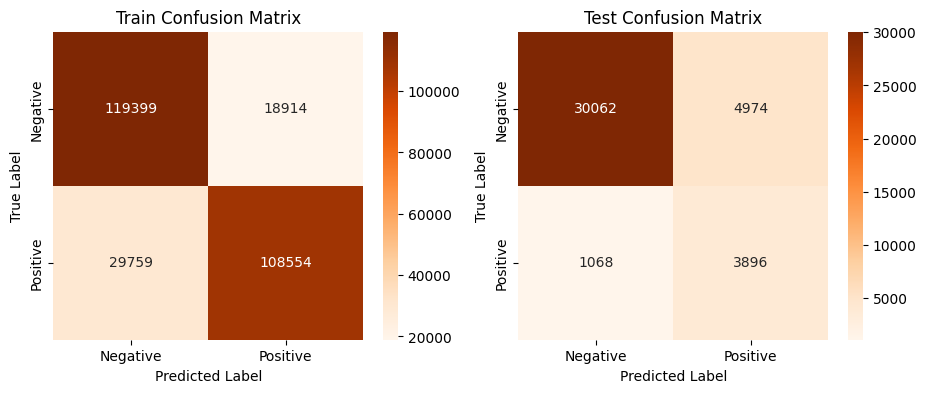


Train Classification Report:
              precision    recall  f1-score        support
0              0.800487  0.863252  0.830686  138313.000000
1              0.851618  0.784843  0.816868  138313.000000
accuracy       0.824048  0.824048  0.824048       0.824048
macro avg      0.826052  0.824048  0.823777  276626.000000
weighted avg   0.826052  0.824048  0.823777  276626.000000

Test Classification Report:
              precision    recall  f1-score      support
0              0.965692  0.858032  0.908684  35036.00000
1              0.439233  0.784851  0.563250   4964.00000
accuracy       0.848950  0.848950  0.848950      0.84895
macro avg      0.702463  0.821441  0.735967  40000.00000
weighted avg   0.900359  0.848950  0.865816  40000.00000


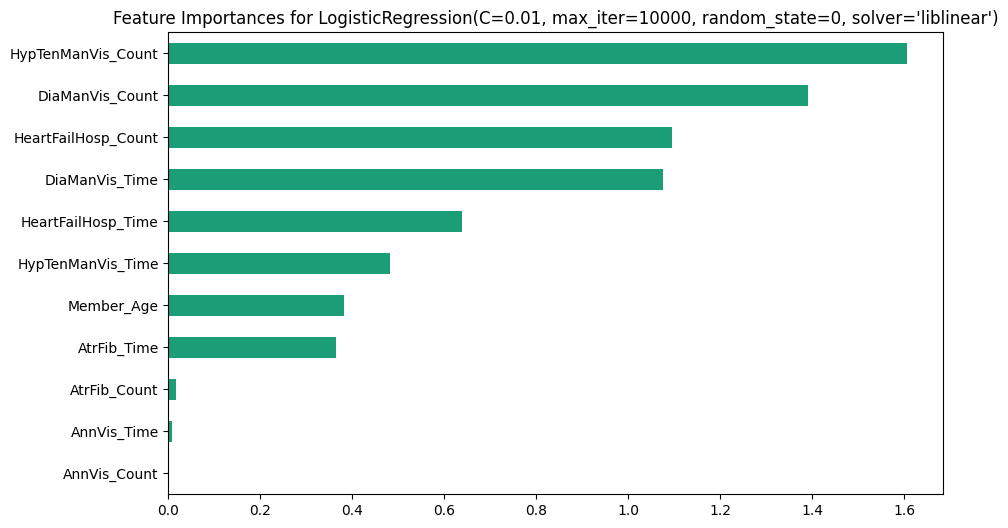

In [45]:
# Visualizing evaluation Metric Score chart
lr_score2 = evaluate_model(lr_model2, X_smote, X_test, y_smote, y_test)

### Evaluation of these results

The difference between the results from our original Logistic Regression model and the hyperparameter tuned one is minimal because the default settings of the Logistic Regression model in Scikit-Learn are already quite effective!

I used the solver 'liblinear' as it is good for small datasets, but it's also possible that other hyperparameters (or combinations of hyperparameters) may yield better results.  e.g., 'saga' or 'newton-cg' For the time being, I will rather pass to other models due to limited time



### using RepeatedStratifiedKFold

In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold

# ML Model - 1 Implementation with hyperparameter optimization techniques (i.e., GridSearch CV, RandomSearch CV, Bayesian Optimization etc.)
# Define the hyperparameter grid
param_grid = {'C': [100,10,1,0.1,0.01,0.001,0.0001],
              'penalty': ['l1', 'l2'],
              'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

# Initializing the logistic regression model
logreg = LogisticRegression(fit_intercept=True, max_iter=10000, random_state=0)

# Repeated stratified kfold
rskf = RepeatedStratifiedKFold(n_splits=3, n_repeats=4, random_state=0)

# Using GridSearchCV to tune the hyperparameters using cross-validation
grid = GridSearchCV(logreg, param_grid, cv=rskf)
grid.fit(X_smote, y_smote)

# Select the best hyperparameters found by GridSearchCV
best_params = grid.best_params_
print("Best hyperparameters: ", best_params)

In [47]:
# Initiate model with best parameters
lr_model2 = LogisticRegression(C=best_params['C'],
                                  penalty=best_params['penalty'],
                                  solver=best_params['solver'],
                                  max_iter=10000, random_state=0)


Train ROC AUC: 0.8874013122306167
Test ROC AUC: 0.8893139808585511


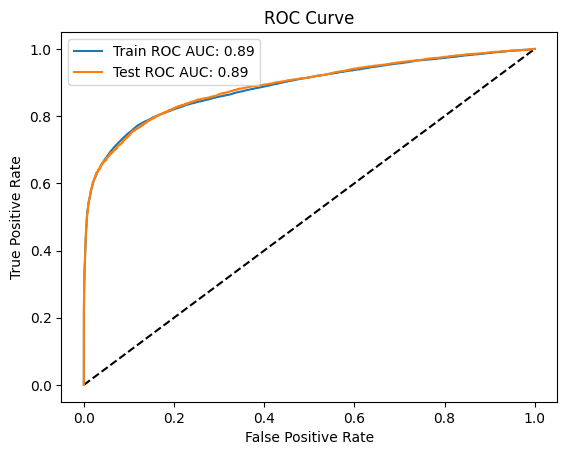

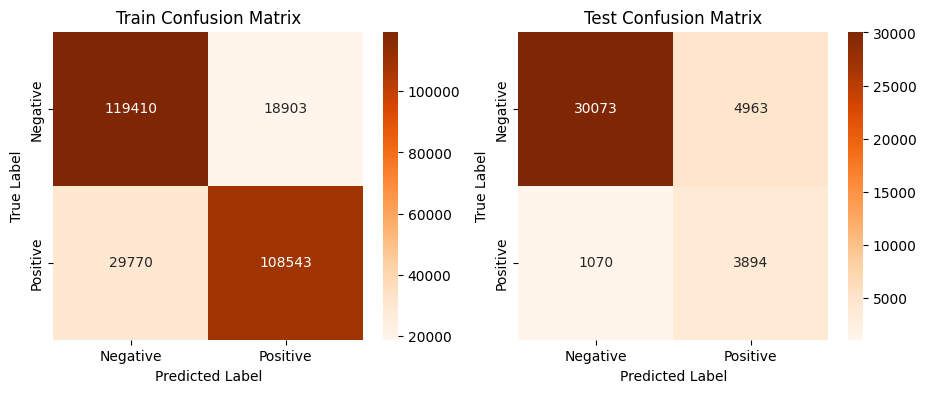


Train Classification Report:
              precision    recall  f1-score        support
0              0.800442  0.863332  0.830698  138313.000000
1              0.851678  0.784764  0.816853  138313.000000
accuracy       0.824048  0.824048  0.824048       0.824048
macro avg      0.826060  0.824048  0.823776  276626.000000
weighted avg   0.826060  0.824048  0.823776  276626.000000

Test Classification Report:
              precision    recall  f1-score       support
0              0.965642  0.858346  0.908838  35036.000000
1              0.439652  0.784448  0.563490   4964.000000
accuracy       0.849175  0.849175  0.849175      0.849175
macro avg      0.702647  0.821397  0.736164  40000.000000
weighted avg   0.900367  0.849175  0.865980  40000.000000


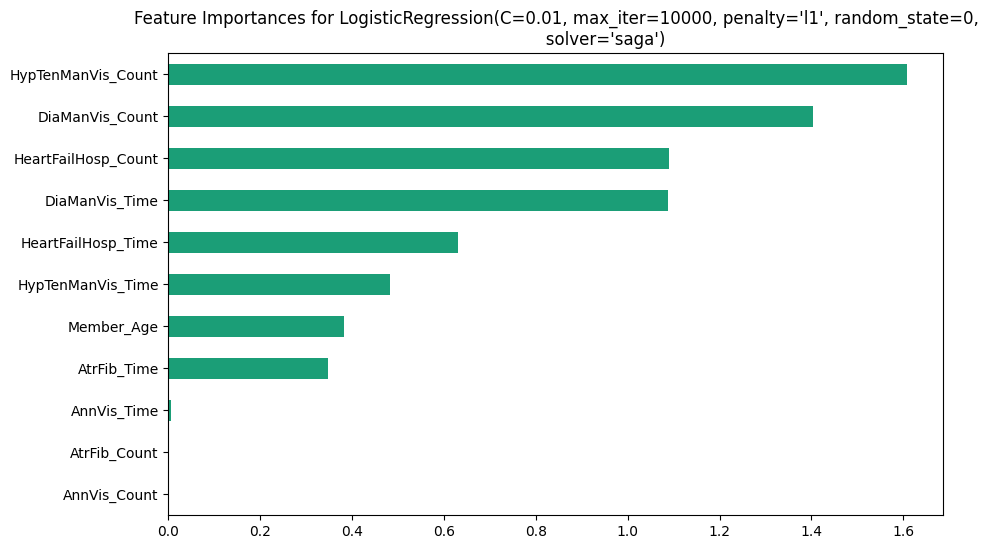

In [48]:
# Visualizing evaluation Metric Score chart
lr_score2 = evaluate_model(lr_model2, X_smote, X_test, y_smote, y_test)

In [49]:
score

,Logistic regression
Precision Train,0.826028
Precision Test,0.900180
Recall Train,0.823957
Recall Test,0.849300
Accuracy Train,0.823957
Accuracy Test,0.849300
ROC-AUC Train,0.887223
ROC-AUC Test,0.889037
F1 macro Train,0.823677
F1 macro Test,0.866035


### Model Evaluation


#### A Brief On Model Evaluation Metrics I Used
• Precision: Think of this as the model's accuracy in predicting positive instances. It answers the question, "When the model predicts a stroke, how often is it correct?"

• Recall (Sensitivity): This is about the model's ability to detect positive instances. The question here is, "When a stroke actually happens, how often does the model detect it?"

• Accuracy: A broad indicator of the model's performance. It asks, "Overall, how often does the model make correct predictions, whether stroke or no stroke?"

• ROC-AUC: A measure of the model's ability to distinguish between classes (stroke vs. no stroke) at different thresholds. A score of 0.5 indicates the model is no better than random guessing, while 1.0 suggests perfect discernment.

• F1 Macro: The harmonic mean of precision and recall, it provides a balanced measure, especially when the class distribution is uneven. The 'macro' refers to how it averages the F1 scores across multiple classes - calculating independently for each and then taking the average, treating all classes equally.


#### Evaluation of results

Looking at these results, it appears that my Logistic Regression model has done a decent job at predicting stroke occurrence (evidenced by the AUC-ROC scores, which are relatively high for both training (0.887) and testing (0.889) datasets)

Interestingly, some of the test scores are slightly higher than the training scores, which is not the usual pattern in machine learning models!!! Typically, models tend to perform better on the training data because they are optimized based on this data. This could be due to either the just random chance (train-test split might have accidentally included easier examples in the test set or harder examples in the training set) orit could be due to regularization and model complexity (techniques like regularization could lead to slightly worse performance on the training set because they prevent overfitting by adding a penalty to the loss function. since they promote better generalization to unseen data, they can result in improved performance on the test set.)

On the other hand, precision, recall, and accuracy scores are all reasonably high, indicating good model performance overall. Specifically, the precision score for the test dataset is quite high (0.90), implying that when our model predicts a patient will have a stroke, it is correct 90% of the time. The recall score (0.849) indicates that our model correctly identifies 84.9% of all stroke patients, which is crucial in a medical context like this. We aim to detect as many stroke cases as possible to provide timely and appropriate medical intervention, even if it might mean a few false alarms (lower precision).


### ML Model - 2 : Decision Tree


Train ROC AUC: 0.9966678495724941
Test ROC AUC: 0.7801080037946925


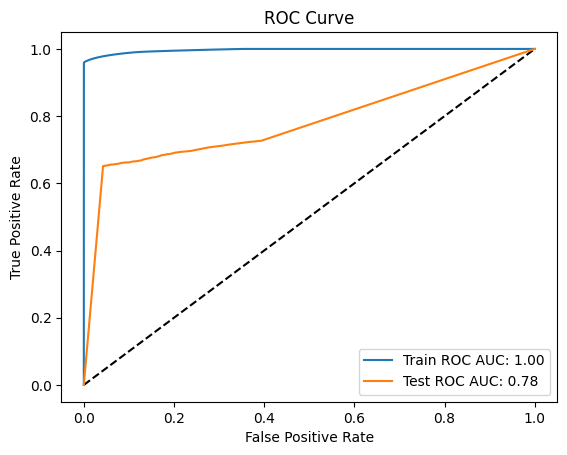

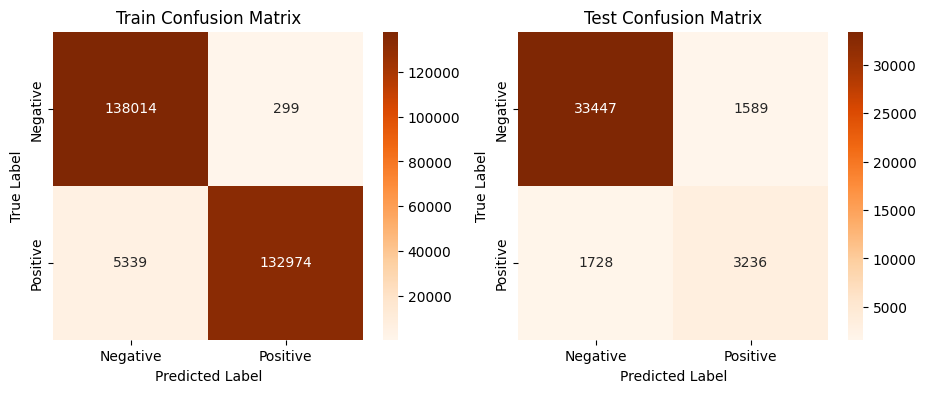


Train Classification Report:
              precision    recall  f1-score        support
0              0.962756  0.997838  0.979983  138313.000000
1              0.997756  0.961399  0.979240  138313.000000
accuracy       0.979619  0.979619  0.979619       0.979619
macro avg      0.980256  0.979619  0.979612  276626.000000
weighted avg   0.980256  0.979619  0.979612  276626.000000

Test Classification Report:
              precision    recall  f1-score       support
0              0.950874  0.954647  0.952757  35036.000000
1              0.670674  0.651894  0.661150   4964.000000
accuracy       0.917075  0.917075  0.917075      0.917075
macro avg      0.810774  0.803270  0.806953  40000.000000
weighted avg   0.916101  0.917075  0.916568  40000.000000


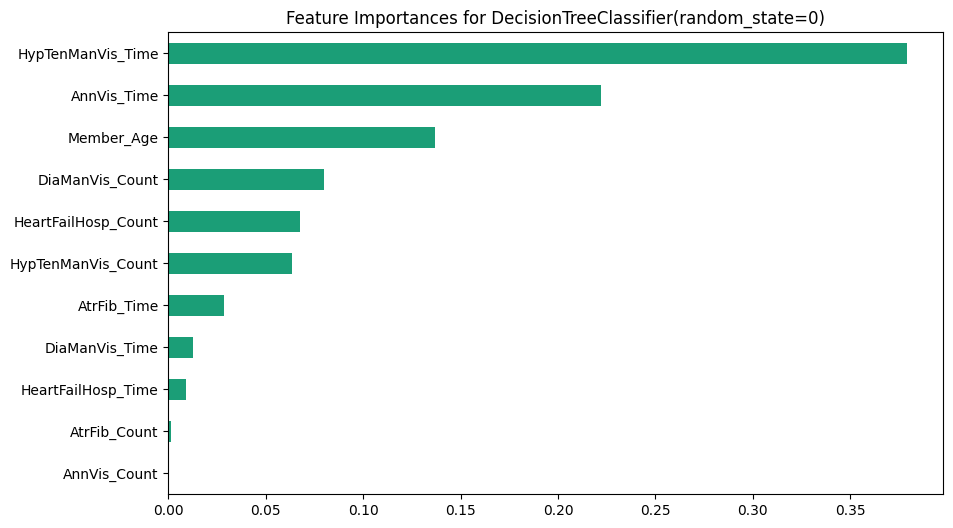

                 Logistic regression  Decision Tree
Precision Train             0.826028       0.980256
Precision Test              0.900180       0.916101
Recall Train                0.823957       0.979619
Recall Test                 0.849300       0.917075
Accuracy Train              0.823957       0.979619
Accuracy Test               0.849300       0.917075
ROC-AUC Train               0.887223       0.996668
ROC-AUC Test                0.889037       0.780108
F1 macro Train              0.823677       0.979612
F1 macro Test               0.866035       0.916568


In [52]:
# ML Model - 2 Implementation
dt_model = DecisionTreeClassifier(random_state=0)  # Set random_state for reproducibility

# Model is trained (fit) and predicted in the evaluate model
# Visualizing evaluation Metric Score chart
dt_score = evaluate_model(dt_model, X_smote, X_test, y_smote, y_test)

# Updated Evaluation metric Score Chart
score['Decision Tree'] = dt_score
print(score)




Best hyperparameters:  {'max_depth': 8, 'min_samples_leaf': 16, 'min_samples_split': 2}

Train ROC AUC: 0.8998931232011924
Test ROC AUC: 0.8936060005368945


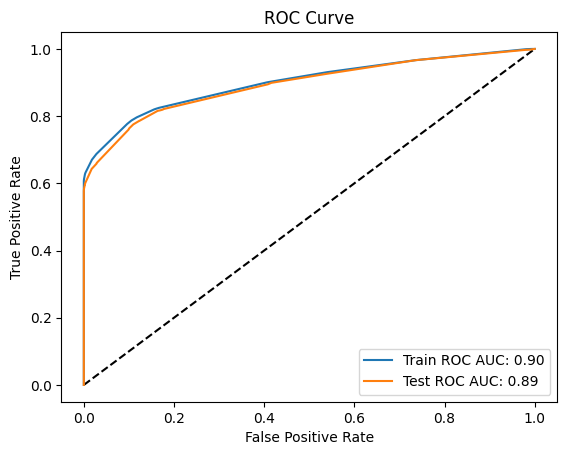

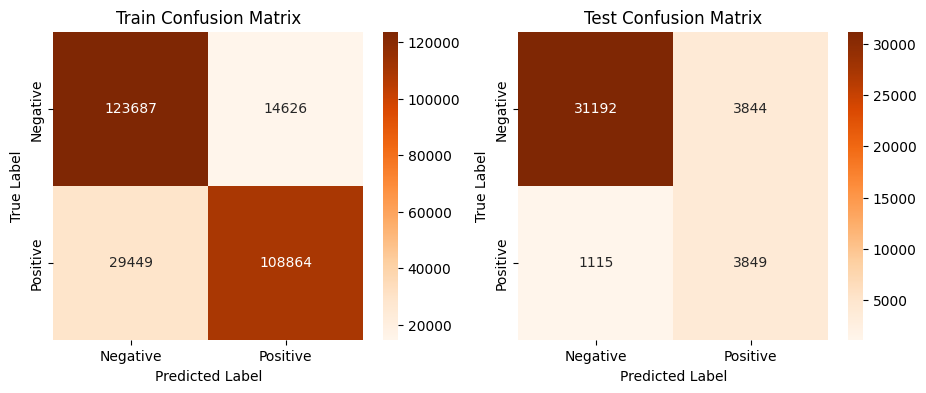


Train Classification Report:
              precision    recall  f1-score        support
0              0.807694  0.894254  0.848773  138313.000000
1              0.881561  0.787084  0.831648  138313.000000
accuracy       0.840669  0.840669  0.840669       0.840669
macro avg      0.844628  0.840669  0.840211  276626.000000
weighted avg   0.844628  0.840669  0.840211  276626.000000

Test Classification Report:
              precision    recall  f1-score       support
0              0.965487  0.890284  0.926362  35036.000000
1              0.500325  0.775383  0.608201   4964.000000
accuracy       0.876025  0.876025  0.876025      0.876025
macro avg      0.732906  0.832834  0.767282  40000.000000
weighted avg   0.907761  0.876025  0.886878  40000.000000


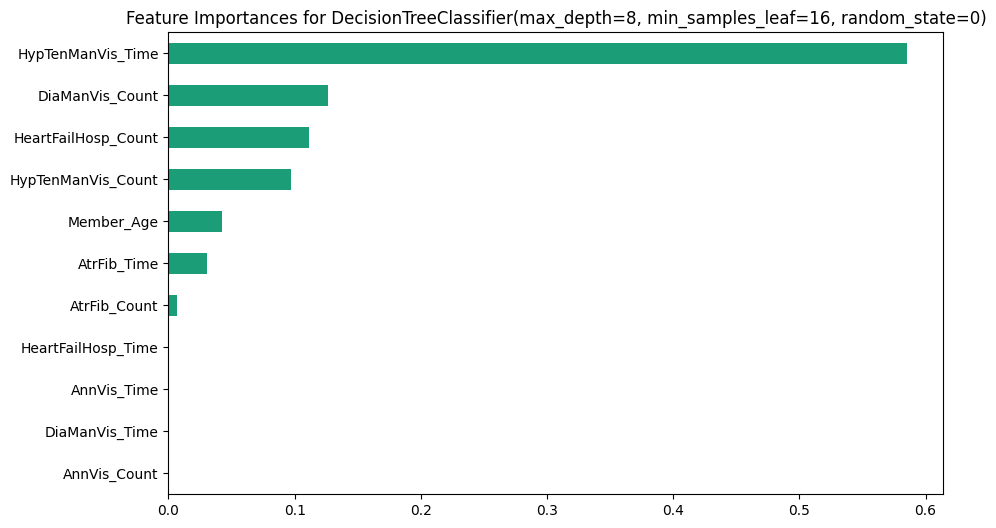

                 Logistic regression  Decision Tree  Decision Tree tuned
Precision Train             0.826028       0.980256             0.844628
Precision Test              0.900180       0.916101             0.907761
Recall Train                0.823957       0.979619             0.840669
Recall Test                 0.849300       0.917075             0.876025
Accuracy Train              0.823957       0.979619             0.840669
Accuracy Test               0.849300       0.917075             0.876025
ROC-AUC Train               0.887223       0.996668             0.899893
ROC-AUC Test                0.889037       0.780108             0.893606
F1 macro Train              0.823677       0.979612             0.840211
F1 macro Test               0.866035       0.916568             0.886878


In [54]:
# ML Model - 2 Implementation with hyperparameter optimization techniques (i.e., GridSearch CV, RandomSearch CV, Bayesian Optimization etc.)
# Define the hyperparameter grid
grid = {'max_depth' : [3,4,5,6,7,8],
        'min_samples_split' : np.arange(2,8),
        'min_samples_leaf' : np.arange(10,20)}

# Initialize the model
model = DecisionTreeClassifier(random_state=0)

# repeated stratified kfold
rskf = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=0)

# Initialize GridSearchCV
grid_search = GridSearchCV(model, grid, cv=rskf)

# Fit the GridSearchCV to the training data
grid_search.fit(X_smote, y_smote)

# Select the best hyperparameters
best_params = grid_search.best_params_
print("Best hyperparameters: ", best_params)

# Train a new model with the best hyperparameters
dt_model2 = DecisionTreeClassifier(max_depth=best_params['max_depth'],
                                   min_samples_leaf=best_params['min_samples_leaf'],
                                   min_samples_split=best_params['min_samples_split'],
                                   random_state=0)

# Visualizing evaluation Metric Score chart
dt2_score = evaluate_model(dt_model2, X_smote, X_test, y_smote, y_test)

score['Decision Tree tuned'] = dt2_score
print(score)

#### Evaluation of results

Note: This step took long!

The initial decision tree model (before hyperparameter tuning) achieved a very high ROC-AUC score on the training data (0.997), but its performance dropped significantly on the test data (0.780). This suggests that the model might be overfitting the training data and thus performing poorly on unseen data. The model's precision and recall scores on the test set were 0.916 and 0.917 respectively, and its accuracy was 0.917.

Tuned Decision Tree Model

After tuning the decision tree model's hyperparameters, I observed an improvement in the test set performance. The ROC-AUC score for the test set increased to 0.894, and the model's accuracy on the test data increased to 0.876. However, this performance was still slightly lower than the logistic regression model's ROC-AUC score. The precision and recall scores were slightly lower than the original decision tree model but had less difference between the training and test sets, indicating a more generalized model.

Summary

While both models showed respectable performance, the logistic regression model achieved the best balance between overfitting and underfitting, showing a high degree of generalization to unseen data. 

### ML Model - 3 : Random Forest

#### Why Random Forest?

The Random Forest (RF) model is a powerful technique that builds upon decision trees. It can handle a large number of features and is relatively immune to overfitting. It is a strong choice for the current project because it can model complex relationships between features.

More facts I like about RF:
- RF is less likely to overfit to the training data compared to a single decision tree, because it averages the results of many individual decision trees.
- RF can handle both continuous and categorical variables, and is not affected by feature scale.
- While RF models are often considered less interpretable than individual decision trees, they still provide valuable information about feature importance.

In my RF model, I adjusted three parameters:

- n_estimators: This is the number of trees in the forest. Generally, a higher number of trees increases the performance and makes the predictions more stable, but it also slows down the computation.
- max_depth: This is the maximum depth of the tree. We need to tune this parameter to avoid overfitting (too high) and underfitting (too low).
- min_samples_split: This is the minimum number of samples required to split an internal node. Higher values prevent a model from learning relations 



Train ROC AUC: 0.9943558037587246
Test ROC AUC: 0.8743432506258787


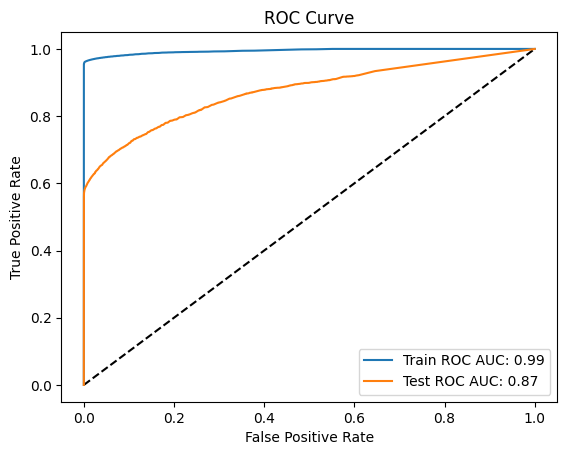

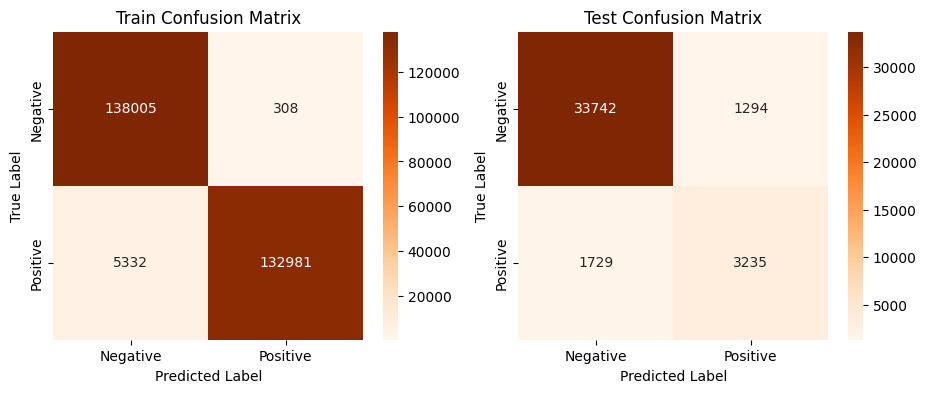


Train Classification Report:
              precision    recall  f1-score        support
0              0.962801  0.997773  0.979975  138313.000000
1              0.997689  0.961450  0.979234  138313.000000
accuracy       0.979611  0.979611  0.979611       0.979611
macro avg      0.980245  0.979611  0.979605  276626.000000
weighted avg   0.980245  0.979611  0.979605  276626.000000

Test Classification Report:
              precision    recall  f1-score       support
0              0.951256  0.963067  0.957125  35036.000000
1              0.714286  0.651692  0.681555   4964.000000
accuracy       0.924425  0.924425  0.924425      0.924425
macro avg      0.832771  0.807379  0.819340  40000.000000
weighted avg   0.921848  0.924425  0.922927  40000.000000


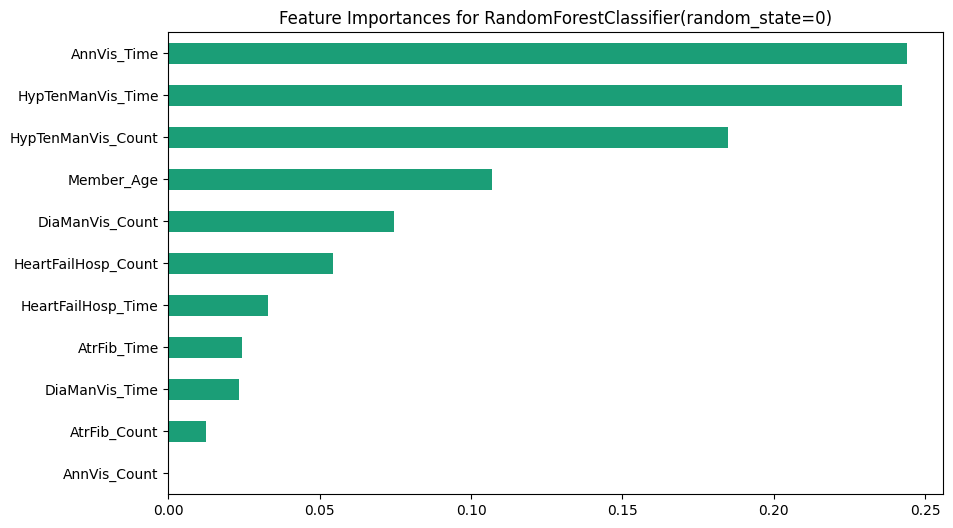

,Logistic regression,Decision Tree,Decision Tree tuned,Random Forest
Precision Train,0.826028,0.980256,0.844628,0.980245
Precision Test,0.900180,0.916101,0.907761,0.921848
Recall Train,0.823957,0.979619,0.840669,0.979611
Recall Test,0.849300,0.917075,0.876025,0.924425
Accuracy Train,0.823957,0.979619,0.840669,0.979611
Accuracy Test,0.849300,0.917075,0.876025,0.924425
ROC-AUC Train,0.887223,0.996668,0.899893,0.994356
ROC-AUC Test,0.889037,0.780108,0.893606,0.874343
F1 macro Train,0.823677,0.979612,0.840211,0.979605
F1 macro Test,0.866035,0.916568,0.886878,0.922927


In [55]:
# ML Model - 3 Implementation
rf_model = RandomForestClassifier(random_state=0)

# Model is trained (fit) and predicted in the evaluate model

# Visualizing evaluation Metric Score chart
rf_score = evaluate_model(rf_model, X_smote, X_test, y_smote, y_test)

# Updated Evaluation metric Score Chart
score['Random Forest'] = rf_score
score



Best hyperparameters:  {'n_estimators': 100, 'min_samples_split': 5, 'max_depth': 15}

Train ROC AUC: 0.9222768933100071
Test ROC AUC: 0.8946661884048998


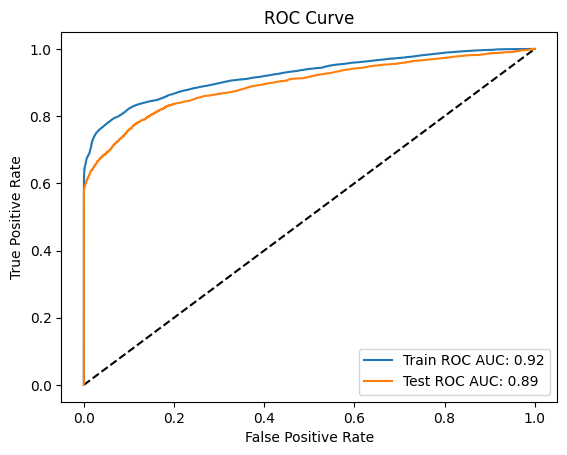

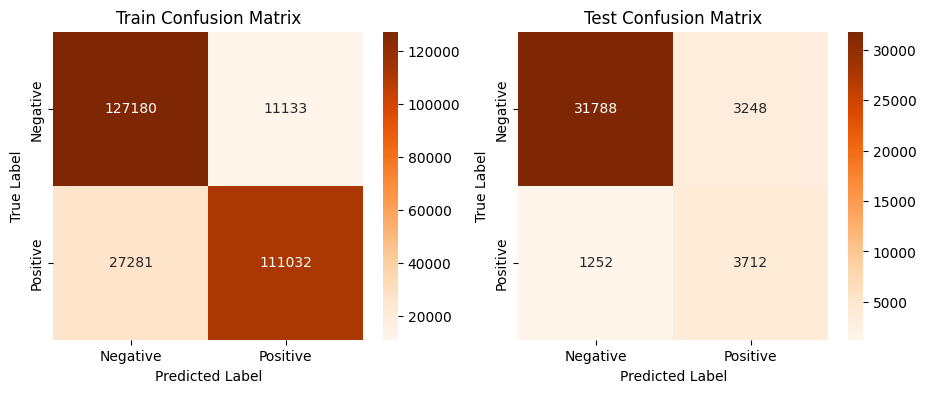


Train Classification Report:
              precision    recall  f1-score        support
0              0.823379  0.919509  0.868793  138313.000000
1              0.908869  0.802759  0.852525  138313.000000
accuracy       0.861134  0.861134  0.861134       0.861134
macro avg      0.866124  0.861134  0.860659  276626.000000
weighted avg   0.866124  0.861134  0.860659  276626.000000

Test Classification Report:
              precision    recall  f1-score     support
0              0.962107  0.907295  0.933897  35036.0000
1              0.533333  0.747784  0.622610   4964.0000
accuracy       0.887500  0.887500  0.887500      0.8875
macro avg      0.747720  0.827540  0.778254  40000.0000
weighted avg   0.908896  0.887500  0.895267  40000.0000


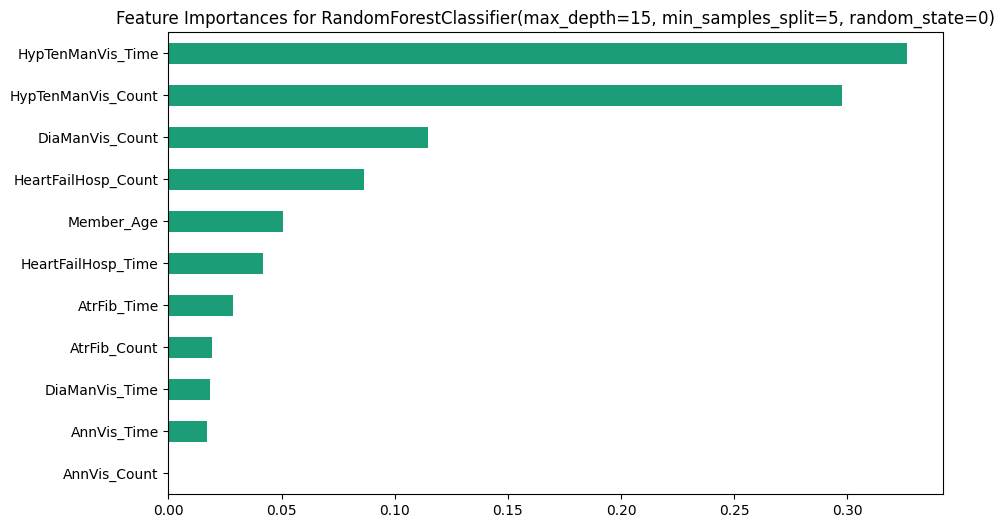

In [56]:
# ML Model - 3 Implementation with hyperparameter optimization techniques (i.e., GridSearch CV, RandomSearch CV, Bayesian Optimization etc.)
# Define the hyperparameter grid
grid = {'n_estimators': [10, 50, 100, 200],
              'max_depth': [8, 9, 10, 11, 12,13, 14, 15],
              'min_samples_split': [2, 3, 4, 5]}

# Initialize the model
rf = RandomForestClassifier(random_state=0)

# Repeated stratified kfold
rskf = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=0)

# Initialize RandomSearchCV
random_search = RandomizedSearchCV(rf, grid,cv=rskf, n_iter=10, n_jobs=-1)

# Fit the RandomSearchCV to the training data
random_search.fit(X_smote, y_smote)

# Select the best hyperparameters
best_params = random_search.best_params_
print("Best hyperparameters: ", best_params)

# Initialize model with best parameters
rf_model2 = RandomForestClassifier(n_estimators = best_params['n_estimators'],
                                 min_samples_split= best_params['min_samples_split'],
                                 max_depth = best_params['max_depth'],
                                 random_state=0)

# Visualizing evaluation Metric Score chart
rf2_score = evaluate_model(rf_model2, X_smote, X_test, y_smote, y_test)

score['Random Forest tuned'] = rf2_score


In [57]:
score

,Logistic regression,Decision Tree,Decision Tree tuned,Random Forest,Random Forest tuned
Precision Train,0.826028,0.980256,0.844628,0.980245,0.866124
Precision Test,0.900180,0.916101,0.907761,0.921848,0.908896
Recall Train,0.823957,0.979619,0.840669,0.979611,0.861134
Recall Test,0.849300,0.917075,0.876025,0.924425,0.887500
Accuracy Train,0.823957,0.979619,0.840669,0.979611,0.861134
Accuracy Test,0.849300,0.917075,0.876025,0.924425,0.887500
ROC-AUC Train,0.887223,0.996668,0.899893,0.994356,0.922277
ROC-AUC Test,0.889037,0.780108,0.893606,0.874343,0.894666
F1 macro Train,0.823677,0.979612,0.840211,0.979605,0.860659
F1 macro Test,0.866035,0.916568,0.886878,0.922927,0.895267


it seems like  the initial Random Forest model was already well optimized, or the range of hyperparameters selected during tuning didn't contain the optimal values.

### ML Model - 4 : Xtreme Gradient Boosting

### Why I love XBoost:

- It is an advanced implementation of gradient boosting algorithm (stands for eXtreme Gradient Boosting). 

- It is renowned for its predictive performance - usually outperforms other algorithms.

- It can be used for both regression and classification, and can handle missing values.

- It includes several regularization parameters that help prevent the model from overfitting. 

- Like other tree-based methods, it provides feature importance scores, making it easier to interpret.



In [4]:
#  Patient Characteristics
patient_event_counts = df['Member_ID'].value_counts()
print("Average number of events per patient:", patient_event_counts.mean())


# Outliers
# Note: The definition of an 'outlier' may vary based on context.
# Here we use a simple definition for the purpose of an example.
Q1 = df['Member_Age'].quantile(0.25)
Q3 = df['Member_Age'].quantile(0.75)
IQR = Q3 - Q1
outlier_condition = (df['Member_Age'] < (Q1 - 1.5 * IQR)) | (df['Member_Age'] > (Q3 + 1.5 * IQR))
outliers = df[outlier_condition]
print("Outliers based on Age:\n", outliers)


Average number of events per patient: 2.55923
Outliers based on Age:
 Empty DataFrame
Columns: [Member_ID, Event_Name, Event_Time_Days, Member_Age]
Index: []


####
 Here's a brief interpretation of these results:

Event Distribution: The most common event is "ANNUAL VISIT", followed by "HYPERTENSION MANAGEMENT VISIT" and "DIABETES MANAGEMENT VISIT". 

On average, each patient has approximately 2.56 clinical events. This might suggest that most patients have multiple conditions or visits.

The average number of days between clinical events is about 189, but there's a large variation (standard deviation of ~161 days). This might suggest that there's quite a bit of variation in how often patients have these events.

There are no missing value, which is great.

There don't appear to be any outliers in the ages, based on the IQR rule for detecting outliers.

There doesn't seem to be strong correlation between the variables. The highest correlation coefficient is between Event_Time_Days and Member_Age but the value is still pretty low (around 0.062). This might suggest that the variables in your dataset are relatively independent of each other.

These insights are valuable as you continue with your machine learning task. For instance, they can help you understand the distribution of your data, identify potential features for your model, and even provide insights on feature engineering possibilities. As you build your model, remember that understanding the data is a key step in the machine learning pipeline.



In [10]:
# Missing Values
missing_values = df.isnull().sum()
print("Missing Values:\n", missing_values)


Missing Values:
 Member_ID          0
Event_Name         0
Event_Time_Days    0
Member_Age         0
dtype: int64


ANNUAL VISIT                     200000
HYPERTENSION MANAGEMENT VISIT    153326
DIABETES MANAGEMENT VISIT         86840
HEART FAILURE HOSPITALIZATION     33606
STROKE HOSPITALIZATION            24821
ATRIAL FIBRILLATION               13253
Name: Event_Name, dtype: int64


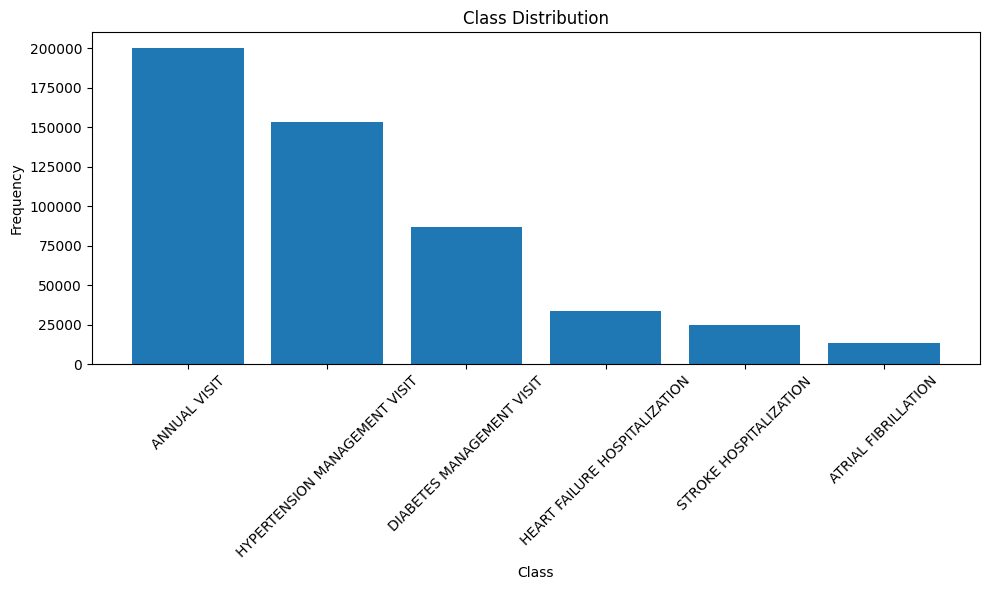

In [15]:

class_counts = df['Event_Name'].value_counts()

print(class_counts)

# Plotting the class distribution
plt.figure(figsize=(10,6))
plt.bar(class_counts.index, class_counts.values)
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Class Distribution')
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.tight_layout()  # Adjusts subplot params to give specified padding
plt.show()


####
It seems like "ANNUAL VISIT" and "HYPERTENSION MANAGEMENT VISIT" are much more common than others, like "STROKE HOSPITALIZATION" or "ATRIAL FIBRILLATION".

This imbalanced dataset might be problematic because stroke hospitalization (class of interest) is underrepresented. The model may show a poor performance in predicting the minority class. Accuracy will not a good metric when dealing this imbalanced datasets.  (precision, recall, F1 score, or AUC-ROC could be better).

By using Synthetic Minority Over-sampling Technique (SMOTE), we can create synthetic samples of the minority class.

(alternatively, we could also use class-weighted / cost-sensitive learning by assigning a higher penalty to misclassified minority classes)


Regarding transforming skewed variables, it would depend on the specific variable and the model you're using

In [ ]:
#First, let's say you're going to split your data into features (X) and the target variable (y), which in your case is 'Event_Name'.
from sklearn.model_selection import train_test_split

# Your feature matrix X and target variable y
X = your_data.drop('Event_Name', axis=1)
y = your_data['Event_Name']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#This code will create a balanced dataset by oversampling the minority class using SMOTE.

#If you want to use SMOTE combined with Tomek links, you can do it like this:
from imblearn.combine import SMOTETomek

smt = SMOTETomek(random_state=42)
X_res, y_res = smt.fit_resample(X_train, y_train)

#This will both oversample the minority class with SMOTE and clean the data using Tomek links, which are pairs of instances of opposite classes who are each other's nearest neighbors. In this case, the Tomek links are removed to make the two classes more separable.

#Remember, the transformed (resampled) data should only be used for training your model. The testing set should remain unbalanced to represent the real-world data distribution.

#Also, it's important to understand that oversampling methods like SMOTE can lead to overfitting since it generates synthetic examples, so always use cross-validation or a separate validation set to validate your model's performance.

In [ ]:
transformed skewed continuous variables into log and square root transformations (cardiovascular)


In [ ]:
### used standard scalar method to ensure that all features were on the same scale. (Cardiovascular)


In [ ]:
### handle imbalanced nature of the dataset via the SMOTE combined with Tomek (cardiovascular)
 links undersampling technique 


In [ ]:
### Standardization using sckitlearn StandardScaler to put the data into similar scale (stroke prediction main)


In [ ]:
### Creating Scatter charts to Understand the Relationship of the Variables. Correlation Analysis Using Heat map (another diabetes)


####
Data transformation ideas 

Event Count: For each patient, you could count the number of each type of clinical event within a certain time frame. This would give you a feature like "Number of Hypertension Management Visits in the first year".

Time Since Last Event: You could calculate the time since the last occurrence of each type of clinical event for each patient. This would give you features like "Days since last Stroke Hospitalization".

First occurrence: You might find the time of the first occurrence of each event useful. This can give insights into when a patient first experienced a specific event.

Pattern Over Time: If you are using advanced machine learning models that can handle sequence data, such as Recurrent Neural Networks (RNN), you could feed the sequence of clinical events directly into your model.

Time to Event: You might be interested in the time from day 0 to the occurrence of a specific event like a stroke. This is often used in survival analysis, a set of statistical methods for analyzing the time until an event of interest occurs.

In [27]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

df = pd.read_csv('cleaned_veteran_data.csv')

# Convert 'Event_Name' to a binary variable indicating whether a given event was a 'STROKE HOSPITALIZATION' or not
df['Stroke_Hospitalization'] = df['Event_Name'].apply(lambda x: 1 if x == 'STROKE HOSPITALIZATION' else 0)

# Drop unnecessary columns
df = df.drop(['Member_ID', 'Event_Name'], axis=1)

# Split the data into features (X) and target (y)
X = df.drop('Stroke_Hospitalization', axis=1)
y = df['Stroke_Hospitalization']

# Split the dataset into training and testing sets, reserving 20% of the data for testing the model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions using the testing set and evaluate the accuracy of the model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model accuracy: {accuracy}")

# Investigate the importance of each feature
importances = model.feature_importances_
feature_importances = pd.DataFrame({'feature': list(X.columns), 'importance': importances})
print(feature_importances.sort_values(by='importance', ascending=False))


Model accuracy: 1.0
           feature  importance
0  Event_Time_Days    0.998792
1       Member_Age    0.001208


In [ ]:
'''
it can not be that perfect
'''

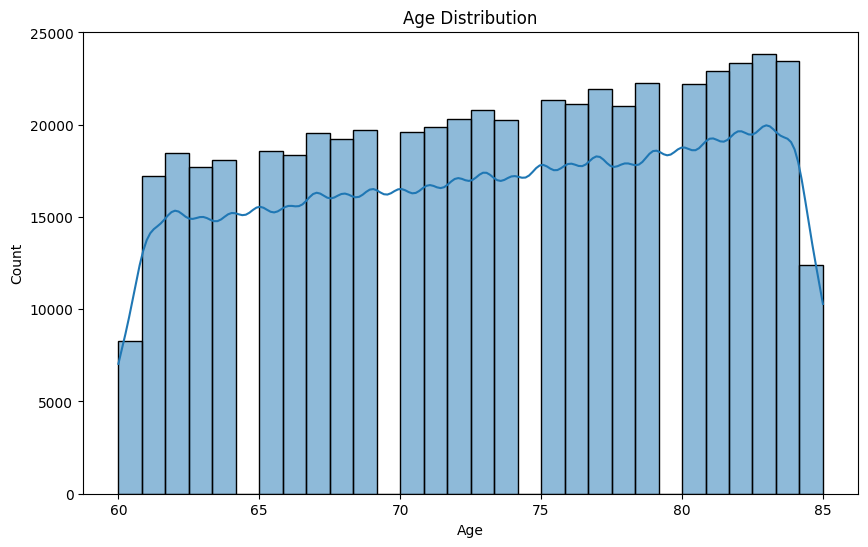

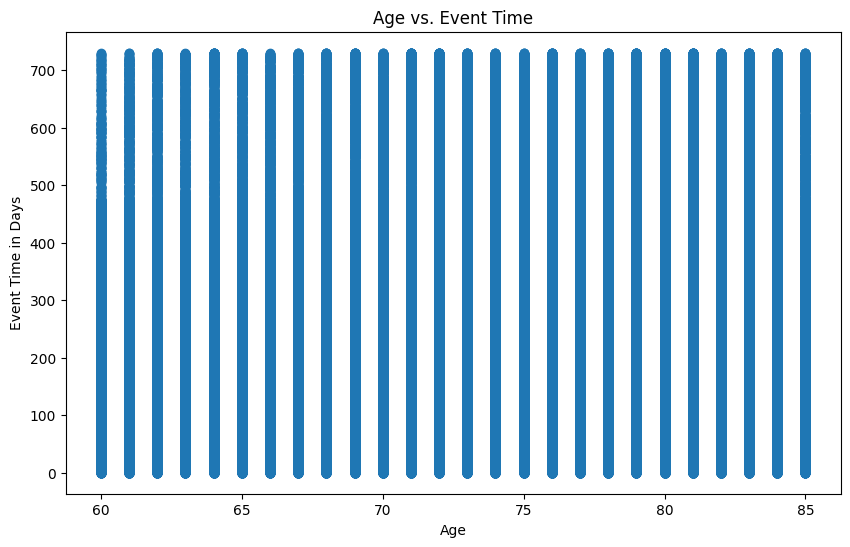

                 Member_ID  Event_Time_Days  Member_Age
Member_ID         1.000000         0.000266   -0.003554
Event_Time_Days   0.000266         1.000000    0.061933
Member_Age       -0.003554         0.061933    1.000000


C:\Users\seyda\AppData\Local\Temp\ipykernel_64000\3280091934.py:23: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


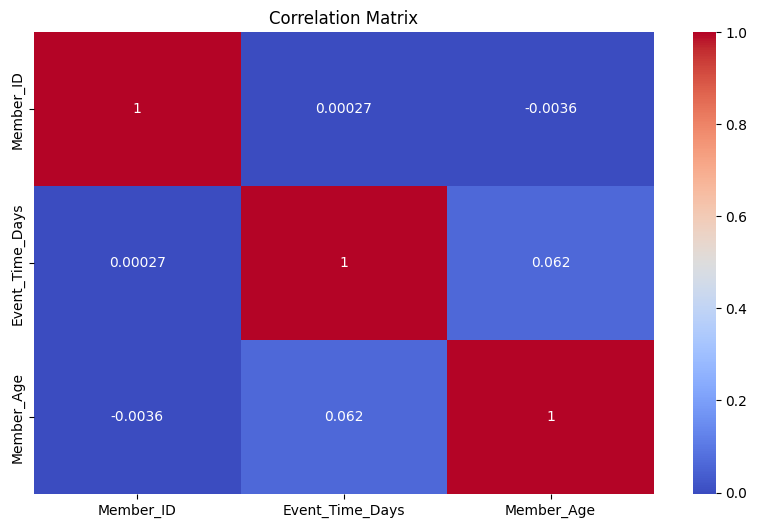

In [30]:
#Discover age  distribution

import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('cleaned_veteran_data.csv')

# Plot the age distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['Member_Age'], kde=True, bins=30)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

# Plot scatter plot to see if age is related to 'Event_Time_Days'
plt.figure(figsize=(10, 6))
plt.scatter(df['Member_Age'], df['Event_Time_Days'])
plt.title('Age vs. Event Time')
plt.xlabel('Age')
plt.ylabel('Event Time in Days')
plt.show()

# Create a correlation matrix
corr_matrix = df.corr()
print(corr_matrix)

# If you want to create a heatmap for visualizing the correlation matrix:
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


In [ ]:
''' patients are 60-85 years old '''


In [31]:
'''
im curious to investigate
whether Event_Time_Days is a significantly better predictor of stroke compared to Member_Age, you can build and compare two separate logistic regression models using each of these predictors.

In these models, the dependent variable (what you're predicting) is whether or not a stroke hospitalization event occurred.

Here is some example Python code using the statsmodels package, which also provides detailed statistical output:

'''
import statsmodels.api as sm

# Prepare the target variable 'stroke_hospitalization'
df['stroke_hospitalization'] = df['Event_Name'].apply(lambda x: 1 if x == 'STROKE HOSPITALIZATION' else 0)

# Define independent (X) and dependent (y) variables for the two models
X_age = sm.add_constant(df['Member_Age'])
X_time = sm.add_constant(df['Event_Time_Days'])
y = df['stroke_hospitalization']

# Build and fit the two models
model_age = sm.Logit(y, X_age).fit()
model_time = sm.Logit(y, X_time).fit()

# Print the model summaries
print(model_age.summary())
print(model_time.summary())


Optimization terminated successfully.
         Current function value: 0.192728
         Iterations 7


C:\Users\seyda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\discrete\discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Current function value: 0.000076
         Iterations: 35


C:\Users\seyda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                             Logit Regression Results                             
Dep. Variable:     stroke_hospitalization   No. Observations:               511846
Model:                              Logit   Df Residuals:                   511844
Method:                               MLE   Df Model:                            1
Date:                    Sat, 15 Jul 2023   Pseudo R-squ.:                0.006831
Time:                            22:49:38   Log-Likelihood:                -98647.
converged:                           True   LL-Null:                       -99326.
Covariance Type:                nonrobust   LLR p-value:                4.505e-297
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.4762      0.070    -78.553      0.000      -5.613      -5.340
Member_Age     0.0338      0.001     36.388      0.000       0.032       0.036
                    

C:\Users\seyda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\discrete\discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


In [ ]:
'''
These results suggest that both Member_Age and Event_Time_Days are statistically significant predictors of stroke hospitalization (given the p-values are less than 0.05). However, it seems that Event_Time_Days is a far more powerful predictor, as indicated by its larger coefficient, and the high pseudo R-squared value (0.9996), which suggests that this variable alone can explain approximately 99.96% of the variability in stroke hospitalization.

Please note the warning about possible complete quasi-separation. Quasi-separation occurs when the outcome variable can be perfectly predicted by one of the predictors. In this case, the logistic regression model might become unstable and its parameters might not be reliable. This is consistent with the output from the Random Forest model, where Event_Time_Days had an importance of nearly 1, suggesting that it was overwhelmingly the most important predictor.

Given this, it's reasonable to infer that Event_Time_Days is indeed a significantly better predictor of stroke compared to Member_Age.

Please note, however, that these results should be interpreted with caution. In particular, the high pseudo R-squared for the Event_Time_Days model and the warning about complete quasi-separation suggest that this variable might be too good to be true as a predictor. It's possible that there are data leakage issues (where future information is unintentionally included in the data), or other data quality or validity issues at play. It would be a good idea to thoroughly understand and validate this variable before relying on it for prediction.
'''


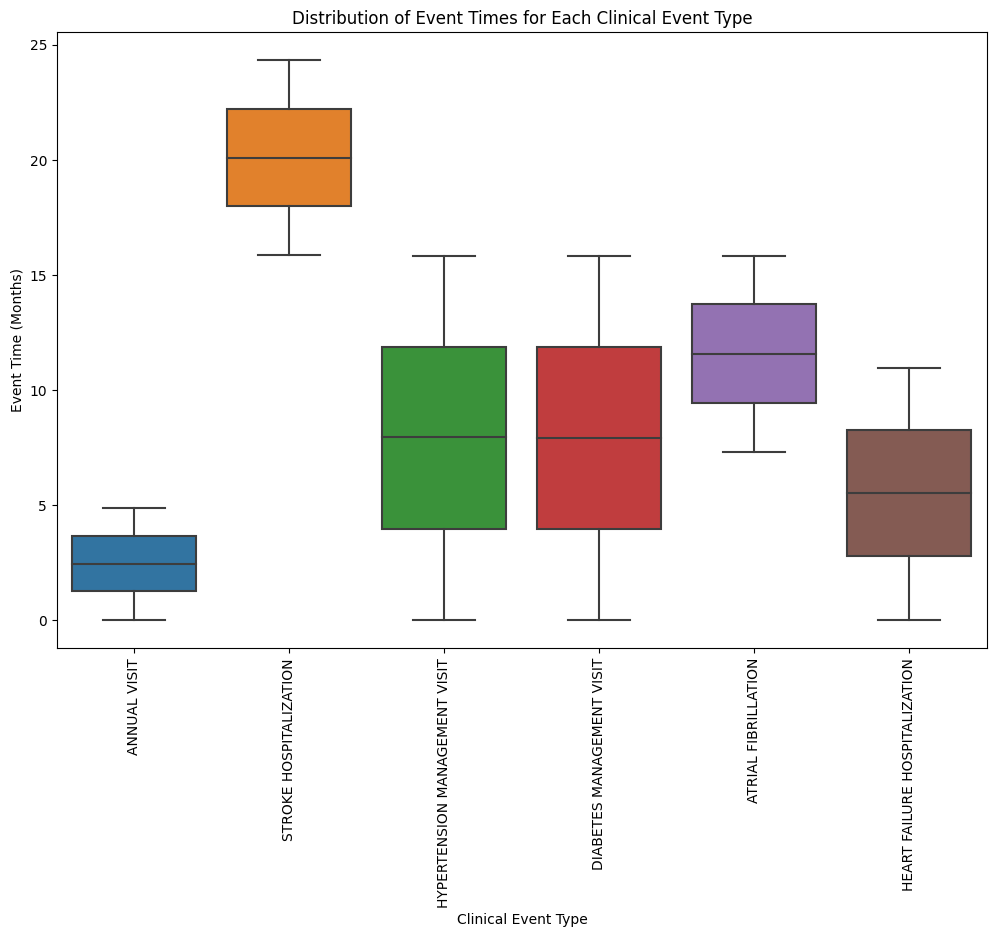

In [34]:


import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load the data
df = pd.read_csv('clinical_events.csv')

# Convert days to months
df['Event_Time_Months'] = df['Event_Time_Days'] / 30

# Create a figure and axes
plt.figure(figsize=(12, 8))

# Plot the data
sns.boxplot(x='Event_Name', y='Event_Time_Months', data=df)

# Set the title and labels
plt.title('Distribution of Event Times for Each Clinical Event Type')
plt.xlabel('Clinical Event Type')
plt.ylabel('Event Time (Months)')
plt.xticks(rotation=90)

plt.show()


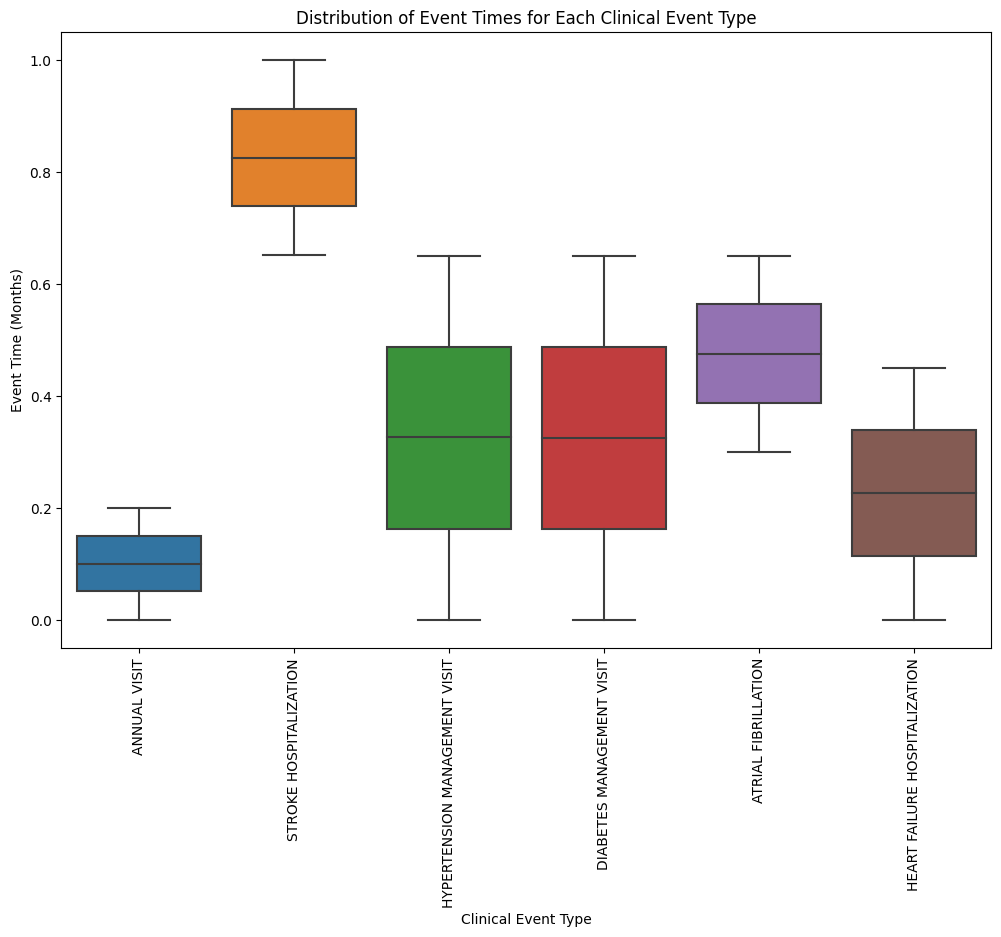

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load the data
df = pd.read_csv('clinical_events.csv')

# Convert hours to months
df['Event_Time_Months'] = df['Event_Time_Days'] / 730

# Create a figure and axes
plt.figure(figsize=(12, 8))

# Plot the data
sns.boxplot(x='Event_Name', y='Event_Time_Months', data=df)

# Set the title and labels
plt.title('Distribution of Event Times for Each Clinical Event Type')
plt.xlabel('Clinical Event Type')
plt.ylabel('Event Time (Months)')
plt.xticks(rotation=90)

plt.show()


In [8]:
'''


Model Development:
In our investigation, we chose a logistic regression model to predict the probability of stroke hospitalization among patients. This selection was made based on several key considerations:

Binary Classification: The problem at hand is a binary classification problem where we are attempting to categorize patients into two classes - those likely to experience a stroke hospitalization and those not likely. Logistic regression is an algorithm well suited for binary classification problems. It estimates the probability that a certain event occurs (i.e., stroke hospitalization), providing a binary outcome based on the computed probabilities.

Interpretability: Logistic regression, unlike some more complex machine learning models, provides clear interpretability. Each feature included in the model is assigned a coefficient which indicates the change in log odds of the outcome for a unit change in the predictor. This ability to directly interpret the impact of predictors is valuable in a healthcare setting, where understanding the basis for predictions can be as important as the predictions themselves.

Efficiency: Logistic regression is a relatively simple and computationally efficient algorithm, meaning it can be trained and applied rapidly even on larger datasets.

Flexibility: Logistic regression allows for easy adjustment and tuning of regularization parameters. This means we can control the complexity of the model, reducing the risk of overfitting by penalizing large coefficients in the logistic regression model.

Feature Scaling and Dimensionality Reduction:
Given the differing ranges of our features - age, event counts, and time to events - we employed feature scaling to ensure that all features contribute equally to the model. We then utilized Principal Component Analysis (PCA) to reduce the dimensionality of our data. PCA helps in simplifying the data structure, removing potential multicollinearity, and enhancing the computational efficiency without losing significant information.

Hyperparameter Tuning:
We performed hyperparameter tuning using Grid Search with cross-validation, optimizing for both the number of components retained by PCA and the logistic regression parameters, 'penalty' and 'C'. Tuning these parameters allowed us to strike a balance between model complexity and prediction accuracy, helping us prevent both underfitting and overfitting.

Model Evaluation:
We evaluated our model based on the Area Under the Receiver Operating Characteristic Curve (AUC-ROC), a robust metric for classification tasks, and reported the best cross-validation AUC-ROC from the hyperparameter tuning process. We also calculated the accuracy on the test set, providing a clear and interpretable measure of the model's performance.

The final model presented is the result of this rigorous development and evaluation process. While it may be beneficial to explore other models or further refine this one, the current logistic regression model offers a solid baseline and an interpretive framework for predicting the risk of stroke hospitalization based on clinical events history.

'''

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

# Load data
df = pd.read_csv('clinical_events_transformed.csv')

#replace all NaN values in your dataframe df with zeros.
#In the context of your dataset, if a NaN value represents that a specific event did not occur for a given patient, it could indeed make sense to replace those NaNs with 0's. In essence, you'd be saying that the 'time since event' is zero for events that did not happen, which could be a reasonable assumption in this context.
#However, please note that replacing NaNs with zeros (or any other constant) is a form of imputation, and it may potentially introduce bias into your data if not handled carefully.
    

df = df.fillna(0)

# Define predictors (X) and target (y)
X = df.drop(['Member_ID', 'Stroke'], axis=1)
y = df['Stroke']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a pipeline with standard scaling, PCA, and logistic regression
pipe = Pipeline([
    ('scale', StandardScaler()),
    ('pca', PCA()),
    ('logistic', LogisticRegression(solver='liblinear'))
])

# Grid for hyperparameter tuning
param_grid = {
    'pca__n_components': list(range(1, 11)), # Try components from 1 to 10
    'logistic__penalty': ['l1', 'l2'],
    'logistic__C': [0.01, 0.1, 1, 10, 100]
}

# Grid search with cross-validation
grid = GridSearchCV(pipe, param_grid, cv=5, scoring='roc_auc')
grid.fit(X_train, y_train)

print("Best parameters: ", grid.best_params_)
print("Best cross-validation score (AUC): ", grid.best_score_)



Best parameters:  {'logistic__C': 0.01, 'logistic__penalty': 'l2', 'pca__n_components': 10}
Best cross-validation score (AUC):  0.8866497305830418


NameError: name 'accuracy_score' is not defined

In [9]:
from sklearn.metrics import accuracy_score
# Evaluate performance on the test set
y_pred = grid.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred)
print(f"Test set accuracy: {accuracy}")
print(f"Test set AUC: {auc_score}")

'''

Great! An accuracy of ~0.938 and an AUC of ~0.777 are decent results for a prediction model.

In the stroke prediction model we've built, we've achieved an accuracy of about 0.938 and an Area Under the Receiver Operating Characteristic curve (AUC-ROC) of about 0.777.

Accuracy refers to the proportion of the total predictions our model makes that are completely correct. In other words, our model correctly predicted whether a patient would have a stroke about 93.8% of the time. While this is a relatively high accuracy, it doesn't give us the complete picture. This is because accuracy doesn't distinguish between the types of errors our model makes (false positives vs. false negatives), which can be crucial in medical diagnosis scenarios.

AUC-ROC is a more comprehensive performance metric for binary classification models, as it considers both the true positive rate (sensitivity) and the false positive rate (1 - specificity) at various threshold settings. The AUC gives us the rate of correctly classifying patients across all thresholds, with 1.0 indicating a perfect model and 0.5 indicating a model that performs no better than random chance. An AUC of 0.777 indicates that our model's ability to distinguish between classes (stroke or no stroke) is good, but there is still room for improvement.


'''

Test set accuracy: 0.937725
Test set AUC: 0.7765786904763797


In [ ]:
''' 
NEXT STEPS

Interpret your model: For a logistic regression model, you can interpret the coefficients to understand how each feature contributes to the predicted outcome. The coefficients can tell you about the relationship between the features and the likelihood of a stroke. You can obtain these coefficients from your trained model with grid.best_estimator_.named_steps['logistic'].coef_.

Evaluate your model more thoroughly: Although accuracy and AUC are common metrics for binary classification, you might want to examine other performance metrics as well, such as precision, recall, and F1 score. This can give you a more comprehensive understanding of your model's performance. You can also use a confusion matrix to visualize true positive, true negative, false positive, and false negative rates.

Feature Importance: If you want to know which features are the most influential in predicting stroke outcome, you can refer to the absolute values of the coefficients in your logistic regression model. The higher the absolute value of a coefficient, the stronger its impact on the model's predictions. You could also employ a feature importance technique such as permutation importance.

Compare to other models: You might also want to try other classification algorithms (like Decision Trees, Random Forests, Gradient Boosting, etc.) to see if they can improve upon the performance of your logistic regression model.

Try to improve your current model: You could revisit the preprocessing stage, feature engineering, and model hyperparameters to see if there are any changes that could improve performance. However, be mindful of the risk of overfitting when continually adjusting your model based on test set performance.

Understand the Misclassifications: It can be helpful to look at the instances where your model made incorrect predictions. Are there common characteristics among these misclassified examples? This can sometimes lead to insights that can help improve the model.

Deploy the model: If you're happy with your model's performance, the next step could be to integrate it into a clinical decision support system or other healthcare software, where it can assist in predicting stroke risk based on patients' health records. This is a big step that involves considerations around software engineering, user interface design, regulatory compliance, etc.

'''


In [12]:
import numpy as np

# Retrieve the logistic regression model and the PCA from the pipeline
logistic_regression_model = grid.best_estimator_.named_steps['logistic']
pca = grid.best_estimator_.named_steps['pca']

# Retrieve the number of components used in PCA
n_components = pca.n_components_

# Create feature names for the principal components
feature_names = [f'Principal Component {i}' for i in range(1, n_components + 1)]

# Retrieve coefficients
coefficients = logistic_regression_model.coef_[0]

# Combine feature names and coefficients into a DataFrame
feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Absolute Coefficient': np.abs(coefficients)
})

# Sort features by absolute coefficient value in descending order
feature_importances = feature_importances.sort_values(by='Absolute Coefficient', ascending=False)

# Display feature importances
print(feature_importances)

'''
Looking at the results:

Principal Component 7 has the highest absolute coefficient, implying that it is the most influential in predicting whether a stroke will occur. It has a negative coefficient, suggesting that as the values along this component increase, the likelihood of a stroke decreases.

Principal Component 1 has the second-highest absolute coefficient and a positive coefficient, suggesting that as its values increase, the likelihood of a stroke also increases.

The other principal components have smaller coefficients, indicating they have less influence on the prediction of a stroke.
'''


                  Feature  Coefficient  Absolute Coefficient
6   Principal Component 7    -1.589528              1.589528
0   Principal Component 1     1.123452              1.123452
3   Principal Component 4    -0.419256              0.419256
7   Principal Component 8     0.307855              0.307855
5   Principal Component 6    -0.273800              0.273800
1   Principal Component 2    -0.236318              0.236318
8   Principal Component 9     0.233151              0.233151
9  Principal Component 10     0.113432              0.113432
2   Principal Component 3     0.078050              0.078050
4   Principal Component 5    -0.035548              0.035548


In [13]:
# Access the best estimator from the grid search
best_estimator = grid.best_estimator_

# Get the PCA step from the pipeline
pca_step = best_estimator.named_steps['pca']

# Get the feature names
feature_names = X_train.columns

# Get the PCA components (eigenvectors)
components = pca_step.components_

# For each component, list the top contributing features
for i, component in enumerate(components):
    component_df = pd.DataFrame(component, index=feature_names, columns=['contribution'])
    component_df['abs_contribution'] = component_df['contribution'].apply(abs)
    component_df = component_df.sort_values('abs_contribution', ascending=False)
    print(f"\nPrincipal Component {i+1}:")
    print(component_df.head(10))
    
'''
This will print out the top 10 features contributing to each principal component. Remember, the contribution can be positive or negative, which refers to the direction of the correlation between the feature and the principal component. A high absolute value of the contribution means the feature strongly influences the component, regardless of the direction of influence.

'''



Principal Component 1:
                                     contribution  abs_contribution
HYPERTENSION_MANAGEMENT_VISIT_Count      0.434590          0.434590
HYPERTENSION_MANAGEMENT_VISIT_Time       0.393922          0.393922
HEART_FAILURE_HOSPITALIZATION_Count      0.361771          0.361771
ATRIAL_FIBRILLATION_Time                 0.346392          0.346392
ATRIAL_FIBRILLATION_Count                0.344315          0.344315
DIABETES_MANAGEMENT_VISIT_Count          0.322458          0.322458
HEART_FAILURE_HOSPITALIZATION_Time       0.321308          0.321308
DIABETES_MANAGEMENT_VISIT_Time           0.271164          0.271164
Member_Age                               0.076046          0.076046
ANNUAL_VISIT_Time                        0.002799          0.002799

Principal Component 2:
                                     contribution  abs_contribution
ATRIAL_FIBRILLATION_Count                0.603208          0.603208
ATRIAL_FIBRILLATION_Time                 0.601967          0.601967


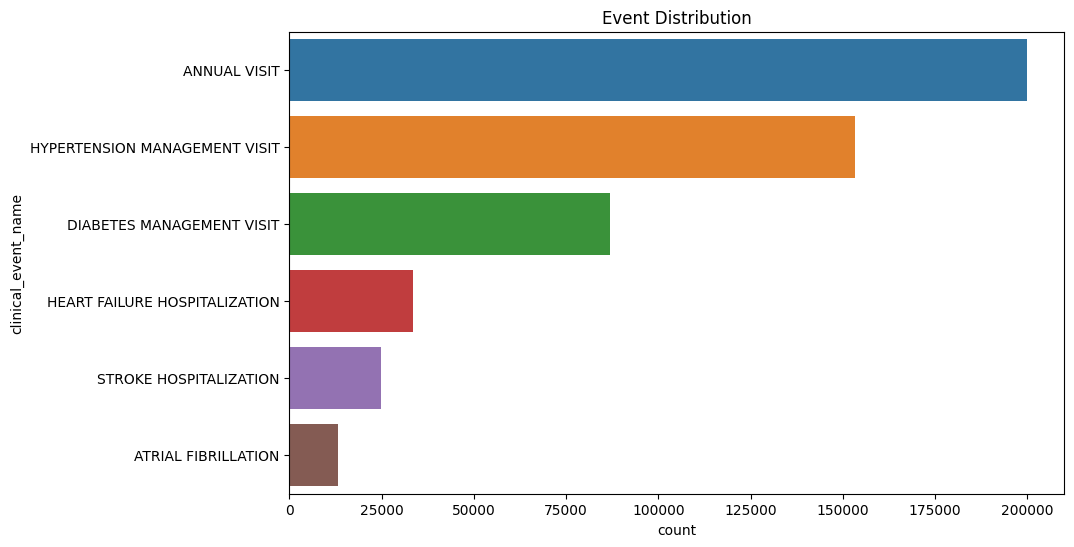

In [18]:
#visualize the event distribution

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.countplot(y='clinical_event_name', data=df, order = df['clinical_event_name'].value_counts().index)
plt.title('Event Distribution')
plt.show()

#"ANNUAL VISIT" and "HYPERTENSION MANAGEMENT VISIT" are the most common events. This could lead you to focus your predictive efforts on these events as they constitute a major part of your data. For instance, if you're creating a classification model, these insights might encourage you to prioritize classifying whether a veteran is likely to have an "ANNUAL VISIT" or "HYPERTENSION MANAGEMENT VISIT".


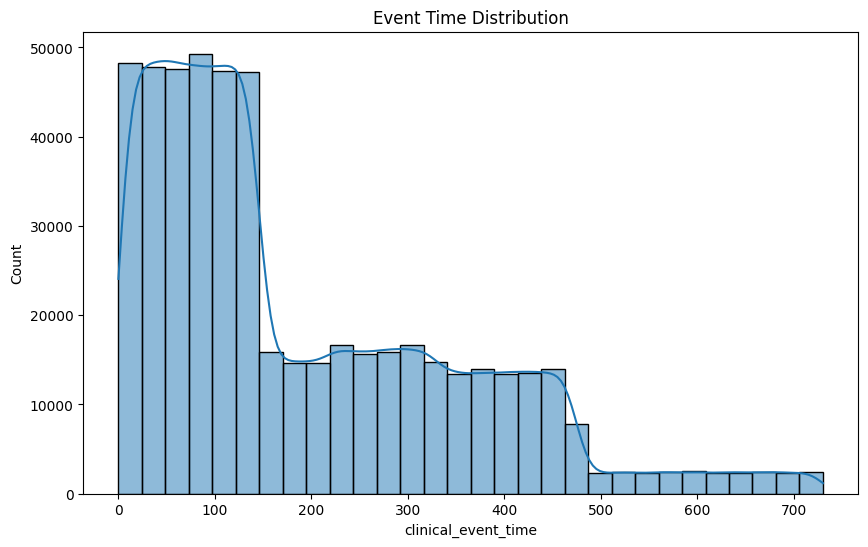

In [20]:
 #distribution of event times:
plt.figure(figsize=(10,6))
sns.histplot(df['clinical_event_time'], bins=30, kde=True)
plt.title('Event Time Distribution')
plt.show()


C:\Users\seyda\AppData\Local\Temp\ipykernel_64000\1142968869.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='coolwarm')


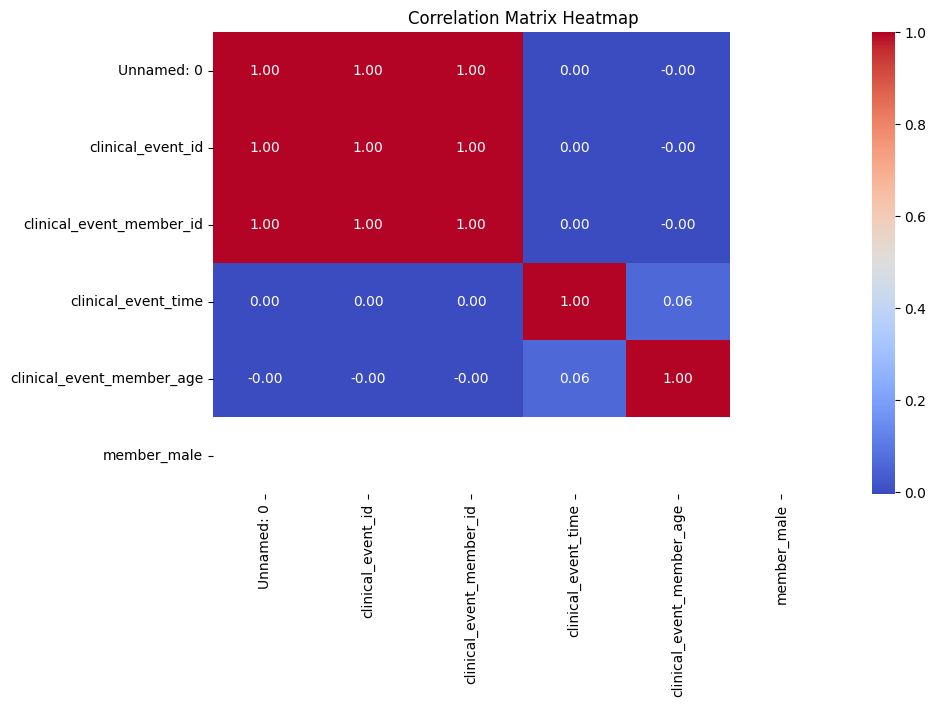

In [21]:
# plot a heatmap of the correlations:
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

#understand the relationships between different features in your dataset. For example, you may find that certain events are more likely to occur as the age of the veteran increases. This could guide your model to pay more attention to the age feature when making predictions for those specific events. However, in your data, the correlations seem weak, suggesting that linear relationships between the variables are not very strong.

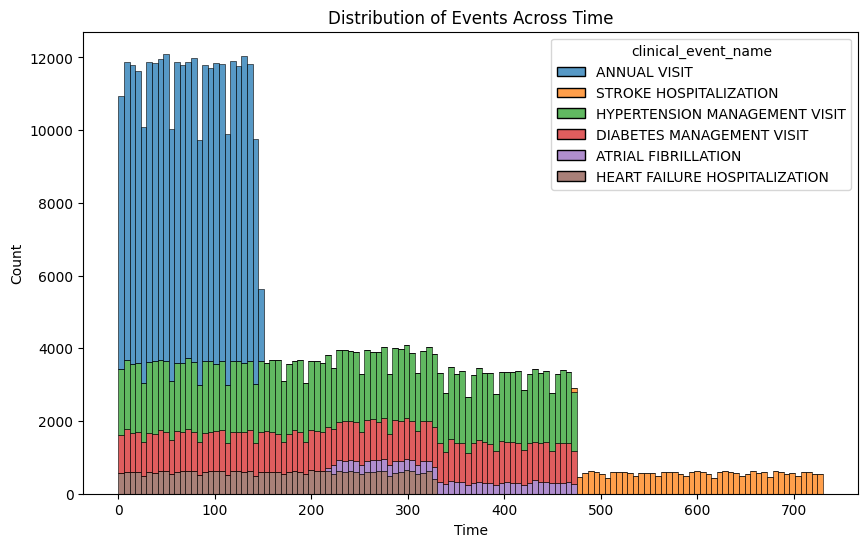

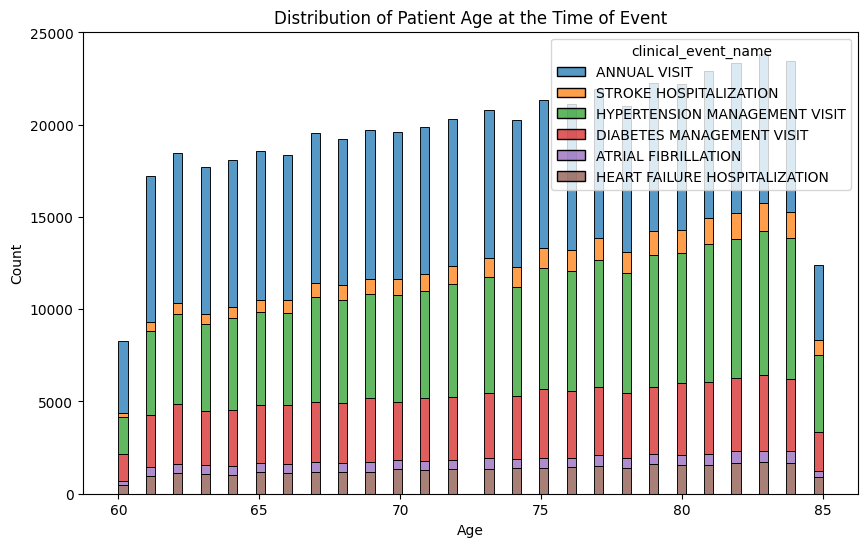

C:\Users\seyda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


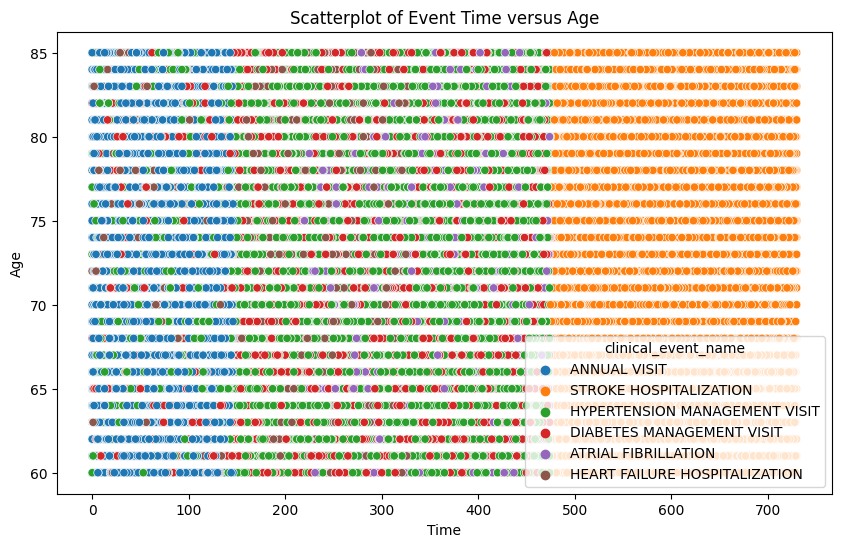

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Event distribution across time
plt.figure(figsize=(10,6))
sns.histplot(data=df, x='clinical_event_time', hue='clinical_event_name', multiple='stack')
plt.title('Distribution of Events Across Time')
plt.xlabel('Time')
plt.ylabel('Count')
plt.show()

# Distribution of patient age at the time of event
plt.figure(figsize=(10,6))
sns.histplot(data=df, x='clinical_event_member_age', hue='clinical_event_name', multiple='stack')
plt.title('Distribution of Patient Age at the Time of Event')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

# Scatterplot of event time versus age
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='clinical_event_time', y='clinical_event_member_age', hue='clinical_event_name')
plt.title('Scatterplot of Event Time versus Age')
plt.xlabel('Time')
plt.ylabel('Age')
plt.show()
